# Higgs analysis for Janka

author: Marcin Wolter, August 2022

In [1]:
! pwd
! ls -lsh
! ls /eos/home-w/wolter/public/jkrzysiak/HADHAD_PNNINPUTS_CSV/

 

/eos/home-i01/w/wolter/SWAN_projects/JKthesis
total 2.4M
1.8M -rw-r--r--. 1 wolter 1307 1.8M Nov  9 15:03 Higgs_Janka_full_background.ipynb
 73K -rw-r--r--. 1 wolter 1307  73K Aug 20 20:35 Higgs_Janka_full_background-kfold.ipynb
435K -rw-r--r--. 1 wolter 1307 435K Mar  3  2022 Higgs_Janka_many_variables-20211205.ipynb
 39K -rw-r--r--. 1 wolter 1307  39K Jan 29  2022 Higgs_Janka_many_variables.ipynb
 12K -rw-r--r--. 1 wolter 1307  12K Aug 31  2021 KERAS test.ipynb
   0 -rw-r--r--. 1 wolter 1307    0 Oct 25 22:39 Normalization_hadhad_btag.txt
171022_Btag  171022_Bveto  btag  btag_261022  bveto  bveto_261022  Zprime


In [2]:
import matplotlib.pyplot as plt
import numpy as np

'''
! pip install tensorflow==2.4.0
! pip install pandas
! pip install sklearn
! pip install keras
'''

import tensorflow as tf
import pandas as pd

from tensorflow.keras import backend
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping

#from tensorflow.keras.utils.vis_utils import plot_model
#from tensorflow.keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Type of data: btag or bveto

In [3]:
#itype = "btag"
itype = "bveto"

datatype = "hadhad"
#datatype = "lephad"

variable_ranking = False
#variable_ranking = True

save_flag = True

Get an azimuthal angle of a sum of 3 vectors

In [4]:
def polar2cart(r, theta):

    x = r  * np.cos(theta)
    y = r  * np.sin(theta)
    return x, y

def cart2polar(x, y):
    theta = np.math.atan2(y, x)
    r     = np.sqrt(x**2 + y**2)
    return (r, theta)

# azimuthal angle and r of a sum of 3 vectors
def angle(pt_0, phi_0, pt_1, phi_1, pt_2, phi_2):
    pt = np.array([pt_0,pt_1,pt_2])
    phi= np.array([phi_0,phi_1,phi_2])
    # convert to cartesian
    x, y = polar2cart(pt, phi)
    # sum these vectors
    xsum = np.sum(x)
    ysum = np.sum(y)
    # find r & phi
    ptsum, phisum = cart2polar(xsum, ysum)
    return ptsum, phisum
   
#   angle between 2 vectors
def angle_between(phi0, phi1):
    
    diff = np.array(phi1-phi0)
    for i in range(len(diff)):
        if diff[i] > np.pi:
            diff[i] = diff[i]-2.*np.pi
        if diff[i] < -np.pi:
            diff[i] = diff[i]+2.*np.pi    

    return diff



Read the cvs input data from google disk and create DataFrame



In [5]:
# Read csv data

#from google.colab import drive
#drive.mount('/content/drive')

if datatype == "lephad":
    
 masses = []
 if variable_ranking:
    masses = [200]
 else:    
    masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]
    #masses = [200, 250, 300, 350, 400, 500, 600, 700, 2500]

 bckg = []
 sig = []
 for i in range(len(masses)):
  print("Mass background = ",masses[i]) 
  bckg_str=[]
  if itype=="bveto":  
   bckg_str= [   
    'Diboson_bveto.csv.gz',
    'Fakes_ID_data_bveto.csv.gz',
    'Fakes_ID_mc_Diboson_bveto.csv.gz',
    'Fakes_ID_mc_Top_single_bveto.csv.gz',
    'Fakes_ID_mc_Top_ttbar_bveto.csv.gz',
    'Fakes_ID_mc_Zll_bveto.csv.gz',
    'Fakes_ID_mc_Ztautau_bveto.csv.gz',
    'Fakes_ISO_data_bveto.csv.gz',
    'Top_single_bveto.csv.gz',
    'Top_ttbar_bveto.csv.gz',
    'Zll_bveto.csv.gz',
    'Ztautau_bveto.csv.gz']
  else:
   bckg_str= [   
    'Diboson_btag.csv.gz',
    'Fakes_ID_data_btag.csv.gz',
    'Fakes_ID_mc_Diboson_btag.csv.gz',
    'Fakes_ID_mc_Top_single_btag.csv.gz',
    'Fakes_ID_mc_Top_ttbar_btag.csv.gz',
    'Fakes_ID_mc_Zll_btag.csv.gz',
    'Fakes_ID_mc_Ztautau_btag.csv.gz',
    'Fakes_ISO_data_btag.csv.gz',
    'Top_single_btag.csv.gz',
    'Top_ttbar_btag.csv.gz',
    'Zll_btag.csv.gz',
    'Ztautau_btag.csv.gz']
        

  bckg_aux = []  
  #bckg_str = '/content/drive/MyDrive/jkrzysiak/data_full/Ztautau_'+str(masses[i])+'GeV.csv'
  for name in bckg_str:
        fname = '../../public/jkrzysiak/data_20211115/'+name
        ### read a 20% fraction of background for b-veto
        if itype == "bveto":
            frac = 1.0 #0.20
        else:
            frac = 1.00
        nn = int(len(pd.read_csv(fname).index)*frac)
        bckg_aux.append(pd.read_csv(fname, nrows=nn))
  
    
  pdaux = pd.concat(bckg_aux) 
  print(pdaux.head())

  
  # replace 'signal_mass' column by masses[i]
  # del pdaux['signal_mass']
  # adding column with mass value
  pdaux['signal_mass'] = pd.Series([masses[i] for x in range(len(pdaux.index))])
  bckg.append(pdaux)  

  sig_aux = []
  if itype=="bveto": 
      #sig_str = '/content/drive/MyDrive/jkrzysiak/data_full/signal_'+str(masses[i])+'GeV.csv'
      sig_str = '../../public/jkrzysiak/data_20211115/bbH_'+str(masses[i])+'GeV_bveto.csv.gz'
      sig_aux.append(pd.read_csv(sig_str) )
      sig_str = '../../public/jkrzysiak/data_20211115/ggH_'+str(masses[i])+'GeV_bveto.csv.gz'
      sig_aux.append(pd.read_csv(sig_str))
  else:
      #sig_str = '/content/drive/MyDrive/jkrzysiak/data_full/signal_'+str(masses[i])+'GeV.csv'
      sig_str = '../../public/jkrzysiak/data_20211115/bbH_'+str(masses[i])+'GeV_btag.csv.gz'
      sig_aux.append(pd.read_csv(sig_str) )
      sig_str = '../../public/jkrzysiak/data_20211115/ggH_'+str(masses[i])+'GeV_btag.csv.gz'
      sig_aux.append(pd.read_csv(sig_str))        

  sig.append(pd.concat(sig_aux))


 #print(bckg)

 XX = []
 YY = []
 WEIGHT = []

 for i in range(len(masses)):
  print("Mass signal = ",masses[i])
  if itype == "bveto":
    ###  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'signal_mass']]
      xs = sig[i][['MTtot', 'tau_pt','lep_pt', 'MET',    'tau_phi-lep_phi',    'tau_phi-MET_phi', 'tau_eta',    'lep_eta', 'signal_mass' ]]
    ###  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'lep_pt', 'MET',	'tau_phi-lep_phi',	'tau_phi-MET_phi', 'tau_eta', 'lep_eta', 'signal_mass']]
    ###  xs = sig[i][['MTtot',  'signal_mass']]
      xsw= sig[i][['weight']]
    ###  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'signal_mass']] #.head(5*len(xs))
      xb = bckg[i][['MTtot', 'tau_pt','lep_pt', 'MET',    'tau_phi-lep_phi',    'tau_phi-MET_phi', 'tau_eta',    'lep_eta', 'signal_mass']] #.head(5*len(xs))
    ###  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'lep_pt', 'MET',	'tau_phi-lep_phi',	'tau_phi-MET_phi', 'tau_eta', 'lep_eta', 'signal_mass']] #.head(5*len(xs))
    ###  xb = bckg[i][['MTtot',  'signal_mass']] #.head(5*len(xs))
      xbw= bckg[i][['weight']] #.head(5*len(xs))
  else:      
    ###  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'signal_mass']]
      xs = sig[i][['MTtot', 'tau_pt','lep_pt', 'MET',    'tau_phi-lep_phi',    'tau_phi-MET_phi', 'tau_eta',    'lep_eta', 'bjet_pt', 'signal_mass' ]]
    ###  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'lep_pt', 'MET',	'tau_phi-lep_phi',	'tau_phi-MET_phi', 'tau_eta', 'lep_eta', 'signal_mass']]
    ###  xs = sig[i][['MTtot',  'signal_mass']]
      xsw= sig[i][['weight']]
    ###  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'signal_mass']] #.head(5*len(xs))
      xb = bckg[i][['MTtot', 'tau_pt','lep_pt', 'MET',    'tau_phi-lep_phi',    'tau_phi-MET_phi', 'tau_eta',    'lep_eta', 'bjet_pt', 'signal_mass']] #.head(5*len(xs))
    ###  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'tau_pt', 'lep_pt', 'MET',	'tau_phi-lep_phi',	'tau_phi-MET_phi', 'tau_eta', 'lep_eta', 'signal_mass']] #.head(5*len(xs))
    ###  xb = bckg[i][['MTtot',  'signal_mass']] #.head(5*len(xs))
      xbw= bckg[i][['weight']] #.head(5*len(xs))
       
    ### Skip angle phi between bjet and Higgs (tau+lep+MET)  higgs_phi_bjet_phi
      '''
    ### Build a new column: angle phi between bjet and Higgs (tau+lep+MET).
      xs_Higgs_pt, xs_Higgs_phi = angle(sig[i]['MET'], sig[i]['MET_phi'], sig[i]['lep_pt'], sig[i]['lep_phi'], sig[i]['tau_pt'], sig[i]['tau_phi']) 
      xb_Higgs_pt, xb_Higgs_phi = angle(bckg[i]['MET'], bckg[i]['MET_phi'], bckg[i]['lep_pt'], bckg[i]['lep_phi'], bckg[i]['tau_pt'], bckg[i]['tau_phi'])
      xs_higgs_phi_bjet_phi = angle_between(xs_Higgs_phi,sig[i][['bjet_phi']] )
      xb_higgs_phi_bjet_phi = angle_between(xb_Higgs_phi,bckg[i][['bjet_phi']] ) 
    ### insert into xs and xb
      xs = xs.assign(higgs_phi_bjet_phi = xs_higgs_phi_bjet_phi)
      xb = xb.assign(higgs_phi_bjet_phi = xb_higgs_phi_bjet_phi)  
      '''
      
    
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["vClass"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["vClass"])


  ### Normalization: each mass point has the same weight
  sum_sw = xsw.sum()
  sum_bw = xbw.sum()
  if i == 0:
    sum_sw0 = sum_sw
    sum_bw0 = sum_bw  
    
  xsw = xsw.mul(sum_bw0 / sum_sw) 
  xbw = xbw.mul(sum_bw0 / sum_bw)
  #xsw = xsw.mul((sum_bw0+sum_sw0)/(sum_bw+sum_sw))
  #xbw = xbw.mul((sum_bw0+sum_sw0)/(sum_bw+sum_sw))*sum_sw/sum_bw0  

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  #print(x.shape, y.shape, w.shape)
  print(xs.shape, ys.shape, xsw.shape)
  print(xb.shape, yb.shape, xbw.shape)


In [6]:
# Read csv data

#from google.colab import drive
#drive.mount('/content/drive')

if datatype == "hadhad":
    
 masses = []
 if variable_ranking:
    masses = [1000]
 else:
    #masses = [300]
    masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1000, 1200, 1500, 2000, 2500]
    #masses = [200, 250, 300, 350, 400, 500, 600, 700, 2500]

 bckg = []
 sig = []
 for i in range(len(masses)):
  print("Mass background = ",masses[i]) 
  bckg_str=[]
  if itype=="bveto":  
   bckg_str= [   
    'bveto_261022/Diboson_BVETO.csv.gz',
    'bveto_261022/Multijet_BVETO.csv.gz',
    'bveto_261022/SingleTop_BVETO.csv.gz',
    'bveto_261022/ttbar_BVETO.csv.gz',
    'bveto_261022/Wjets_BVETO.csv.gz',
    'bveto_261022/Zll_BVETO.csv.gz',
    'bveto_261022/Ztautau_BVETO.csv.gz'
    ]
  else:
   bckg_str= [   
    'btag_261022/Diboson_BTAG.csv.gz',
    'btag_261022/Multijet_BTAG.csv.gz',
    'btag_261022/SingleTop_BTAG.csv.gz',
    'btag_261022/ttbar_BTAG.csv.gz',
    'btag_261022/Wjets_BTAG.csv.gz',
    'btag_261022/Zll_BTAG.csv.gz',
    'btag_261022/Ztautau_BTAG.csv.gz'
    ]   
        

  bckg_aux = []  
  #bckg_str = '/content/drive/MyDrive/jkrzysiak/data_full/Ztautau_'+str(masses[i])+'GeV.csv'
  for name in bckg_str:
        fname = '../../public/jkrzysiak/HADHAD_PNNINPUTS_CSV/'+name
        ### read a 20% fraction of background for b-veto
        if itype == "bveto":
            frac = 0.10 #0.20
        else:
            frac = 0.20 #1.00
        nn = int(len(pd.read_csv(fname).index)*frac)
        bckg_aux.append(pd.read_csv(fname, nrows=nn))
  
    
  pdaux = pd.concat(bckg_aux) 
  #print(pdaux.head())

  
  # replace 'signal_mass' column by masses[i]
  # del pdaux['signal_mass']
  # adding column with mass value
  pdaux['sig_mass'] = pd.Series([masses[i] for x in range(len(pdaux.index))])
  print(pdaux.head())
  bckg.append(pdaux)  

  sig_aux = []
  if itype=="bveto": 
      #sig_str = '/content/drive/MyDrive/jkrzysiak/data_full/signal_'+str(masses[i])+'GeV.csv'
      sig_str = '../../public/jkrzysiak/HADHAD_PNNINPUTS_CSV/bveto_261022/bbH'+str(masses[i])+'_BVETO.csv.gz'
      sig_aux.append(pd.read_csv(sig_str) )
      sig_str = '../../public/jkrzysiak/HADHAD_PNNINPUTS_CSV/bveto_261022/ggH'+str(masses[i])+'_BVETO.csv.gz'
      sig_aux.append(pd.read_csv(sig_str))
  else:
      #sig_str = '/content/drive/MyDrive/jkrzysiak/data_full/signal_'+str(masses[i])+'GeV.csv'
      sig_str = '../../public/jkrzysiak/HADHAD_PNNINPUTS_CSV/btag_261022/bbH'+str(masses[i])+'_BTAG.csv.gz'
      sig_aux.append(pd.read_csv(sig_str) )
      sig_str = '../../public/jkrzysiak/HADHAD_PNNINPUTS_CSV/btag_261022/ggH'+str(masses[i])+'_BTAG.csv.gz'
      sig_aux.append(pd.read_csv(sig_str))        

  sig.append(pd.concat(sig_aux))


 #print(bckg)

 XX = []
 YY = []
 WEIGHT = []

 for i in range(len(masses)):
  print("Mass signal = ",masses[i])
  if itype == "bveto":
      xs = sig[i][["mTtot","tau_pt0","tau_pt1", "MET_met","MET_SumET","mvis","deltaEta","deltaR", "cosMETtaudPhi", "sumjetpt", "sig_mass"  ]]
      xsw= sig[i][['weight']]
      xb = bckg[i][["mTtot","tau_pt0","tau_pt1", "MET_met","MET_SumET","mvis","deltaEta","deltaR", "cosMETtaudPhi", "sumjetpt", "sig_mass"]] #.head(5*len(xs))
      xbw= bckg[i][['weight']] #.head(5*len(xs))
  else:      
      #xs = sig[i][["mTtot", "sig_mass" ]]
      xs = sig[i][["mTtot","tau_pt0","tau_pt1", "MET_met","MET_SumET","mvis","deltaEta","deltaR", "cosMETtaudPhi", "sumjetpt", "sig_mass" ]]
      xsw= sig[i][['weight']]
      #xb = bckg[i][["mTtot", "sig_mass"]] #.head(5*len(xs))
      xb = bckg[i][["mTtot","tau_pt0","tau_pt1", "MET_met","MET_SumET","mvis","deltaEta","deltaR", "cosMETtaudPhi", "sumjetpt", "sig_mass"]] #.head(5*len(xs))
      xbw= bckg[i][['weight']] #.head(5*len(xs))
       

      
    
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["vClass"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["vClass"])


  ### Normalization: each mass point has the same weight
  sum_sw = xsw.sum()
  sum_bw = xbw.sum()
  if i == 0:
    sum_sw0 = sum_sw
    sum_bw0 = sum_bw  
    
  xsw = xsw.mul(sum_bw0 / sum_sw) 
  xbw = xbw.mul(sum_bw0 / sum_bw)
  #xsw = xsw.mul((sum_bw0+sum_sw0)/(sum_bw+sum_sw))
  #xbw = xbw.mul((sum_bw0+sum_sw0)/(sum_bw+sum_sw))*sum_sw/sum_bw0  

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  #print(x.shape, y.shape, w.shape)
  print(xs.shape, ys.shape, xsw.shape)
  print(xb.shape, yb.shape, xbw.shape)


Mass background =  200
   eventNumber          mTtot           mvis        tau_pt0        tau_pt1  \
0    5404391.0  226783.456342  220581.537144   88295.164062   85813.726562   
1    5408844.0  390154.533137  299352.082682  140485.953125   69111.625000   
2    5500733.0  283646.989106  217563.141856   90839.937500   78038.867188   
3    5503749.0  520256.684322  304926.681059  213239.828125  112248.765625   
4    5505648.0  301692.439648  240458.154318  144719.843750  100069.531250   

         MET_met      MET_SumET   MET_phi  deltaEta    deltaR  ...  tau_phi1  \
0   63239.592871  361756.412659  2.299299  1.458177  3.165532  ...  2.237701   
1  198150.251494  625729.178619 -2.453754  1.977423  3.407370  ...  3.087591   
2  163744.227361  786619.877258 -1.192227  1.496058  3.385001  ...  1.698829   
3  204541.719834  451109.088726 -2.587241  0.096878  2.788084  ... -2.193718   
4   59164.834447  322066.052856  0.341793  0.020765  3.052791  ...  0.734078   

   tau_eta0  tau_eta1  cosM

Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 




In [7]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=0.60, shuffle=True, random_state=42)



(7799084, 11) (7799084, 1) (7799084, 1)


Plot mT_tot for signal (for each mass point) and for background. Use train dataset.

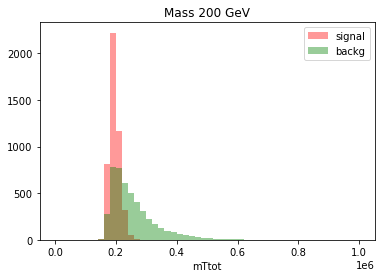

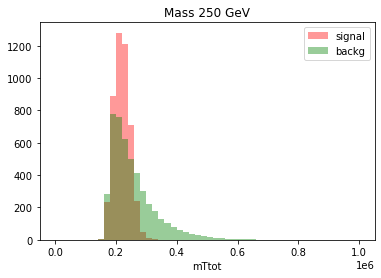

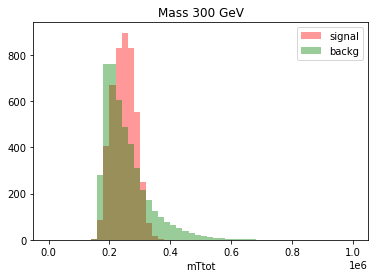

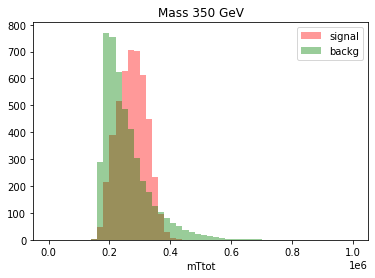

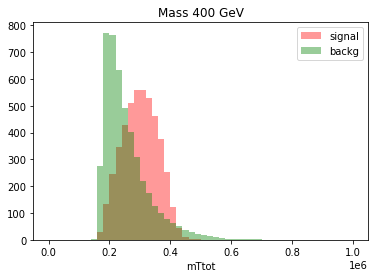

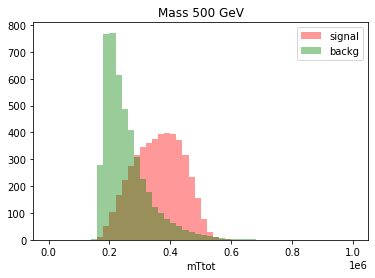

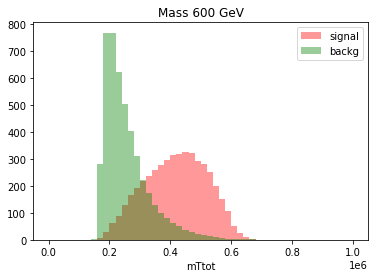

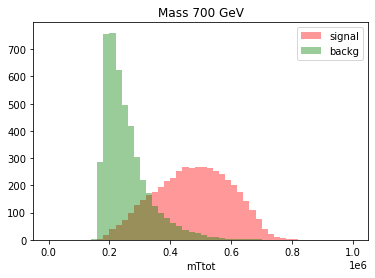

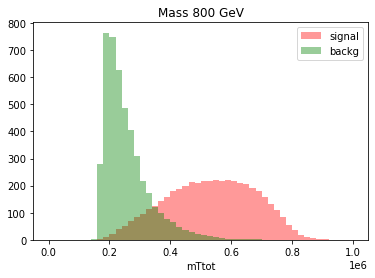

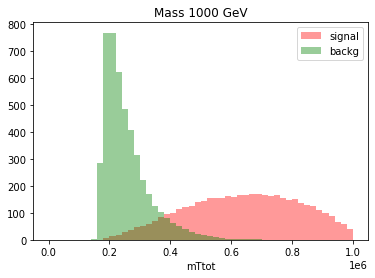

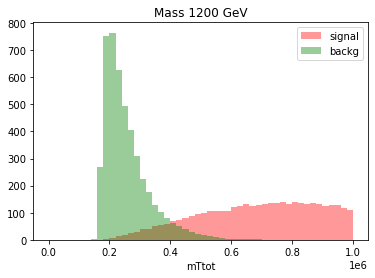

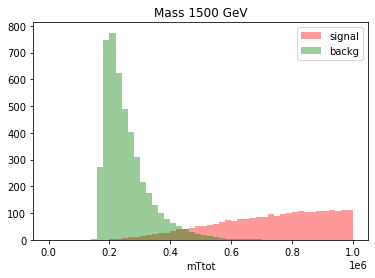

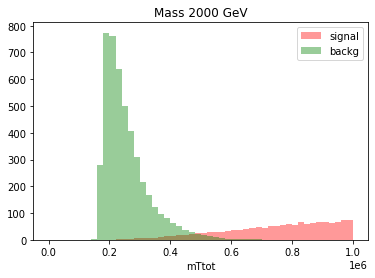

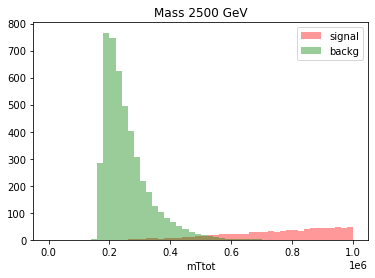

In [8]:
for m in masses:
    # Plotting the histogram.
    #select events with a given signal_mass from the training dataset...    
    if datatype == 'lephad':  
        maskm = np.in1d(x_train_all.signal_mass, m)
    if datatype == 'hadhad':
        maskm = np.in1d(x_train_all.sig_mass, m)
    masks = np.in1d(y_train_all, 1)
    maskb = np.in1d(y_train_all, 0)
    plt.hist(x_train_all[maskm & masks].mTtot, weights=sw_train_all[maskm & masks], bins=50, density=False, 
             alpha=0.4, color='r',range=(0,1e6), label='signal')
    plt.hist(x_train_all[maskm & maskb].mTtot, weights=sw_train_all[maskm & maskb], bins=50, density=False, 
             alpha=0.4, color='g',range=(0,1e6), label='backg')
    plt.xlabel('mTtot')
    plt.title('Mass '+ str(m) + ' GeV')
    plt.legend(prop={'size': 10})
    plt.show()

Normalize training and test data

In [9]:

from sklearn.preprocessing import StandardScaler

if datatype == "hadhad":
    mass_name = 'sig_mass'
if datatype == "lephad":
    mass_name = 'signal_mass'
    

print("MWMW before norm: ",x_train_all[0:3]) 
cols = x_train_all.columns
print(cols[0:-1])
scaler = StandardScaler(copy=False).fit(x_train_all[cols[0:-1]])
x_train_all[cols[0:-1]] = scaler.transform(x_train_all[cols[0:-1]])
# divide mass by 1000
x_train_all[mass_name] = x_train_all[mass_name] / 10000.
print("MWMW after norm: ",x_train_all[0:3]) 

print(scaler.mean_)
print(scaler.scale_)

print("MWMW before norm: ",x_test_all[0:3]) 
cols = x_test_all.columns
print(cols[0:-1])
scaler = StandardScaler(copy=False).fit(x_test_all[cols[0:-1]])
x_test_all[cols[0:-1]] = scaler.transform(x_test_all[cols[0:-1]])
# divide mass by 1000
x_test_all[mass_name] = x_test_all[mass_name] / 10000.
print("MWMW after norm: ",x_test_all[0:3]) 


print("Normalization:")
print("MEAN: ",scaler.mean_)
print("SCALE: ",scaler.scale_)
'''
! pwd
! ls '/eos/user/w/wolter/public/jkrzysiak/'
aux = "/eos/user/w/wolter/public/jkrzysiak/Normalization_"+datatype+"_"+itype+".txt"
! rm -f aux
with open(aux, "a") as file:
    file.write(x_test_all[0:3]+'\n')
    file.write('Mean:\n')
    file.write(scaler.mean_ +'\n')
    file.write('Scale:\n')
    file.write(scaler.scale_ +'\n')
'''    

MWMW before norm:                  mTtot       tau_pt0        tau_pt1        MET_met  \
51338   426025.063754  218026.78125  172050.546875   53929.140843   
61438   338271.236435  169778.75000  132018.265625   36484.090562   
161188  500446.722388  243187.12500  148294.062500  109271.149282   

            MET_SumET           mvis  deltaEta    deltaR  cosMETtaudPhi  \
51338   543776.539581  384503.071690  0.162671  2.853171       0.155495   
61438   340488.470398  366909.102349  1.319126  3.373806      -0.007125   
161188  451147.857025  402981.684558  0.696795  3.169691       0.000111   

             sumjetpt  sig_mass  
51338   125170.406250     500.0  
61438        0.000000    1500.0  
161188   49936.064453     300.0  
Index(['mTtot', 'tau_pt0', 'tau_pt1', 'MET_met', 'MET_SumET', 'mvis',
       'deltaEta', 'deltaR', 'cosMETtaudPhi', 'sumjetpt'],
      dtype='object')


/tmp/ipykernel_16883/1900081305.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_all[cols[0:-1]] = scaler.transform(x_train_all[cols[0:-1]])
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set o

MWMW after norm:             mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
51338   0.092834  0.102327  0.386390 -0.251627   0.123355 -0.107568 -1.069990   
61438  -0.238550 -0.235255 -0.032016 -0.489857  -0.528145 -0.159206  0.221217   
161188  0.373872  0.278369  0.138094  0.504127  -0.173503 -0.053334 -0.473629   

          deltaR  cosMETtaudPhi  sumjetpt  sig_mass  
51338  -1.053157       1.414079  0.188932      0.05  
61438   0.196416       0.081457 -0.708260      0.15  
161188 -0.293480       0.140750 -0.350330      0.03  
[ 4.01441714e+05  2.03401940e+05  1.35081510e+05  7.23551478e+04
  5.05286052e+05  4.21153634e+05  1.12099579e+00  3.29196896e+00
 -1.70650636e-02  9.88118583e+04]
[2.64810033e+05 1.42922444e+05 9.56779223e+04 7.32275912e+04
 3.12030864e+05 3.40719963e+05 8.95638562e-01 4.16650065e-01
 1.22030061e-01 1.39513611e+05]
MWMW before norm:                 mTtot       tau_pt0        tau_pt1        MET_met  \
49924   3.000576e+05  171363.46875  

/tmp/ipykernel_16883/1900081305.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_all[cols[0:-1]] = scaler.transform(x_test_all[cols[0:-1]])
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on 

MWMW after norm:             mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
49924  -0.383115 -0.224661 -0.610623 -0.217863  -0.107465 -0.518695 -0.436352   
4245    0.138211  0.105214  0.464180 -0.424242   0.032556  0.434035  0.766125   
109753  3.005899  2.496773  2.186191  3.033168   2.400908  1.975710  0.307288   

          deltaR  cosMETtaudPhi  sumjetpt  sig_mass  
49924  -0.286545      -0.092142  0.089255      0.02  
4245    0.639981       0.394486 -0.340811      0.08  
109753 -0.321898      -0.852507  0.562899      0.04  
Normalization:
MEAN:  [ 4.01577196e+05  2.03516528e+05  1.35067007e+05  7.24119264e+04
  5.05527511e+05  4.20985992e+05  1.12003244e+00  3.29154343e+00
 -1.69843831e-02  9.89170325e+04]
SCALE:  [2.64984798e+05 1.43118202e+05 9.56568844e+04 7.32610007e+04
 3.12636240e+05 3.40118384e+05 8.94826678e-01 4.16112309e-01
 1.22034407e-01 1.39697541e+05]


/tmp/ipykernel_16883/1900081305.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_all[mass_name] = x_test_all[mass_name] / 10000.


'\n! pwd\n! ls \'/eos/user/w/wolter/public/jkrzysiak/\'\naux = "/eos/user/w/wolter/public/jkrzysiak/Normalization_"+datatype+"_"+itype+".txt"\n! rm -f aux\nwith open(aux, "a") as file:\n    file.write(x_test_all[0:3]+\'\n\')\n    file.write(\'Mean:\n\')\n    file.write(scaler.mean_ +\'\n\')\n    file.write(\'Scale:\n\')\n    file.write(scaler.scale_ +\'\n\')\n'

In [10]:
# convert class vectors to binary class matrices
#y_train_all = tf.keras.utils.to_categorical(y_train_all, 2)
#y_test_all =  tf.keras.utils.to_categorical(y_test_all, 2)

In [11]:

'''
# WARNING
# MWMW if weight < 0 then move an event to the opposite category:
n_sig = 0
n_bkg = 0
n_negsig = 0
n_negbkg = 0

print(y_train_all)

for k in range(len(sw_train_all)):
    if (k % 100000 == 0):
        print(k)
    #print(k)
    #print(y_train_all.iloc[k])
    if y_train_all.iloc[k].at['vClass'] == 1:
        n_sig = n_sig+1
    else:
        n_bkg = n_bkg+1
    if sw_train_all.iloc[k].at["weight"] < 0:
         #print(k," signal  ",sw_train_all.loc[k].at["weight"])
         if y_train_all.iloc[k].at['vClass'] == 1:
            n_negsig = n_negsig + 1
         else:
            n_negbkg = n_negbkg + 1
         y_train_all.iloc[k].at['vClass'] = abs(y_train_all.iloc[k].at['vClass'] - 1)   
         sw_train_all.iloc[k].at["weight"] = - sw_train_all.iloc[k].at["weight"]

print(y_train_all)
print(sw_train_all)
         
print(n_negsig," events out of total ",n_sig," signal ev. had negative weight (tagged as background).")   
print(n_negbkg," events out of total ",n_bkg," bkg ev. had negative weight (tagged as signal).") 
'''


# WARNING: take absolute values of weights for training!!!
###sw_train_all = sw_train_all.abs()

#print(sw_train_all)

  

# WARNING: set negative weights to zero
#print(sw_train_all[sw_train_all>0])  
#sw_train_all[sw_train_all<0] = 0
#print(sw_train_all[sw_train_all>0])  

'\n# WARNING\n# MWMW if weight < 0 then move an event to the opposite category:\nn_sig = 0\nn_bkg = 0\nn_negsig = 0\nn_negbkg = 0\n\nprint(y_train_all)\n\nfor k in range(len(sw_train_all)):\n    if (k % 100000 == 0):\n        print(k)\n    #print(k)\n    #print(y_train_all.iloc[k])\n    if y_train_all.iloc[k].at[\'vClass\'] == 1:\n        n_sig = n_sig+1\n    else:\n        n_bkg = n_bkg+1\n    if sw_train_all.iloc[k].at["weight"] < 0:\n         #print(k," signal  ",sw_train_all.loc[k].at["weight"])\n         if y_train_all.iloc[k].at[\'vClass\'] == 1:\n            n_negsig = n_negsig + 1\n         else:\n            n_negbkg = n_negbkg + 1\n         y_train_all.iloc[k].at[\'vClass\'] = abs(y_train_all.iloc[k].at[\'vClass\'] - 1)   \n         sw_train_all.iloc[k].at["weight"] = - sw_train_all.iloc[k].at["weight"]\n\nprint(y_train_all)\nprint(sw_train_all)\n         \nprint(n_negsig," events out of total ",n_sig," signal ev. had negative weight (tagged as background).")   \nprint(n_negb

In [12]:
# Define normalization of input data
#layer = preprocessing.Normalization()
#layer.adapt(x_train_all.to_numpy())

Prepare a small fully connected network

In [13]:
# prepare keras model

if datatype=='lephad':
 if itype=='bveto':  
    input_shape = (9,)
 else:
    input_shape = (10,) #input_shape = (11,)

if datatype=='hadhad':
 if itype=='bveto':  
    input_shape = (11,)
    #input_shape = (2,)
 else:
    input_shape = (11,) 
    #input_shape = (2,)
    
    
def define_model():
  n_nodes = 256 #512 #256 #16 #128
  dropout = 0.05
  ###dropout = 0.08
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_shape=input_shape))  # input_shape=(5,)
  #model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  #model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [14]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")

  '''
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=False)
  '''  
  def lr_schedule(epoch, lr):
    decay_rate = 0.96
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        #return lr * pow(decay_rate, np.floor(epoch / decay_step))
        return lr * decay_rate
    return lr
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #learning_rate=lr_schedule)

  def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
  lr_metric = get_lr_metric(optimizer) 

  #metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', # 'mse'  'binary_crossentropy'
              optimizer=optimizer) #"sgd",
              # metrics=[tf.keras.metrics.AUC(name='auc'),lr_metric])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=8,
    verbose=2,
    restore_best_weights=True
  )

  callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

  epochs = 200
  #epochs = 3
  batch_size=128
  
  print("fitting")
  history = model.fit(x_train, y_train, 
                    sample_weight=sw_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val, sw_val),
                    callbacks=[es,callback])




  return history, model
#sample_weight = sw_train,

K-folding

In [15]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    print("Defining model")
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("Fit_model")
    print("WARNING: take absolute values of weights for training!!!")
    trainSW = np.abs(trainSW)
    testSW  = np.abs(testSW)
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    print("Fit_model")
    ###loss, auc, _  = model.evaluate(testX, testY, verbose=0)
    loss = model.evaluate(testX, testY, verbose=0)
    print(loss, auc)
    # stores scores
    scores.append(loss)
    histories.append(history)
    models.append(model)

    if save_flag:
        #save model
        if itype=="bveto":
            aa = "bveto"
        else:
            aa="btag"
        aux = '/eos/user/w/wolter/public/jkrzysiak/model_lowlevMTtot_absw_'+datatype+"_"+aa+"_"+str(len(models)-1)
        auxh5 = aux+".h5"
        auxmod = aux+"_mod.h5"
        auxjson = aux+".json"
        ### MWMW skip saving the model
        print(" Saving ",aux)
        ! ls /eos/user/w/wolter/public/jkrzysiak/
        # now we save architecture as a json string and weights in HDF5 file
        ###model.save(aux)
        # get the architecture as a json string
        arch = model.to_json()
        # save the architecture string to a file somehow, the below will work
        with open(auxjson, 'w') as arch_file:
            arch_file.write(arch)
        # now save the weights as an HDF5 file
        model.save_weights(auxh5)
        model.save(auxmod)
    
    
    # break the loop to avoid k-folding
    break

  return scores, histories, models

Plot learning curves and summary of training

In [16]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    ###plt.title('Classification AUC')
    ###plt.plot(histories[i].history['auc'], color='blue', label='train')
    ###plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    ###plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [17]:
def network_fit(np_x_train_all, np_y_train_all, np_sw_train_all):


  #convert to numpy
  print(type(np_y_train_all))
  if not (type(np_x_train_all) is np.ndarray):
      print("Converting to numpy")
      np_x_train_all = np_x_train_all.to_numpy()
  if not (type(np_y_train_all) is np.ndarray):  
      np_y_train_all = np_y_train_all.to_numpy()
  if not (type(np_sw_train_all)  is np.ndarray):      
      np_sw_train_all = np_sw_train_all.to_numpy()
      print("Converted to numpy")
  
  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  ### MWMW skip normalization
  ### np_x_train_all = np.array(layer(np_x_train_all))
  # normalize input data
  # Define normalization of input data
  #normalize = preprocessing.Normalization()
  #normalize.adapt(np_x_train_all)  
  ### MWMW skip normalization
  #np_x_train_all = np.array(normalize(np_x_train_all))
  # alternative
  #np_x_train_all = tf.keras.utils.normalize(np_x_train_all, axis = -1)


  # Train the network. 
  n_folds = 10  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [18]:
if variable_ranking:
    from sklearn.inspection import permutation_importance
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
    from sklearn.metrics import roc_curve 
    
    def plot_roc_curve(fper, tper):  
        plt.plot(fper, tper, color='orange', label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()
    
    if not (type(x_train_all) is np.ndarray):
        np_x_train_all = x_train_all.to_numpy()
    if not (type(y_train_all) is np.ndarray):
        np_y_train_all = y_train_all.to_numpy().reshape(-1)
    if not (type(sw_train_all) is np.ndarray):
        np_sw_train_all = sw_train_all.to_numpy().reshape(-1)
    if not (type(x_test_all) is np.ndarray):
        np_x_test_all = x_test_all.to_numpy()
    if not (type(y_test_all) is np.ndarray):
        np_y_test_all = y_test_all.to_numpy().reshape(-1)
    if not (type(sw_test_all) is np.ndarray):
        np_sw_test_all = sw_test_all.to_numpy().reshape(-1)    
    
    #clf =  RandomForestClassifier(max_depth=5, n_estimators=200)
    clf =  AdaBoostClassifier( DecisionTreeClassifier(max_depth=6), algorithm="SAMME", n_estimators=200)
    #clf = QuadraticDiscriminantAnalysis()
    #clf = LinearDiscriminantAnalysis()
    
    #clf.fit(np_x_train_all, np_y_train_all, abs(np_sw_train_all))
    clf.fit(np_x_train_all, np_y_train_all)
    
    probs = clf.predict_proba(np_x_test_all)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(np_y_test_all, probs) 
    plot_roc_curve(fper, tper)
    
    probs = clf.predict_proba(np_x_train_all)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(np_y_train_all, probs) 
    plot_roc_curve(fper, tper)
    
    result = permutation_importance(
        clf, np_x_test_all, np_y_test_all,  n_repeats=10, random_state=42, n_jobs=2
    )
    
    '''
    ! pip install shap
    import shap
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(np_xtest_all)
    shap.summary_plot(shap_values,np_xtest_all)
    '''
    
    sorted_importances_idx = result.importances_mean.argsort()
    print("Importances: ",result.importances_mean)
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=x_train_all.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

In [19]:
# train the network
if variable_ranking != True:
    scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
32903/32903 [==============================] - 283s 8ms/step - loss: 0.0093 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/200
32903/32903 [==============================] - 142s 4ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 9.6000e-05
Epoch 3/200
32903/32903 [==============================] - 142s 4ms/step - loss: 0.0080 - val_loss: 0.0079 - lr: 9.2160e-05
Epoch 4/200
32903/32903 [==============================] - 147s 4ms/step - loss: 0.0080 - val_loss: 0.0079 - lr: 8.8474e-05
Epoch 5/200
32903/32903 [==============================] - 144s 4ms/step - loss: 0.0079 - val_loss: 0.0077 - lr: 8.4935e-05
Epoch 6/200
32903/32903 [==============================] - 143s 4ms/step - loss: 0.0079 - val_loss: 0.0078 - lr: 8.1537e-05
Epoch 7/200
32903/32903 [==============================] - 144s 4ms/step - loss: 0.0078 - val_loss: 0.0078 - lr: 7.8276e-05
Epoch 8/200


Make plots

dict_keys(['loss', 'val_loss', 'lr'])


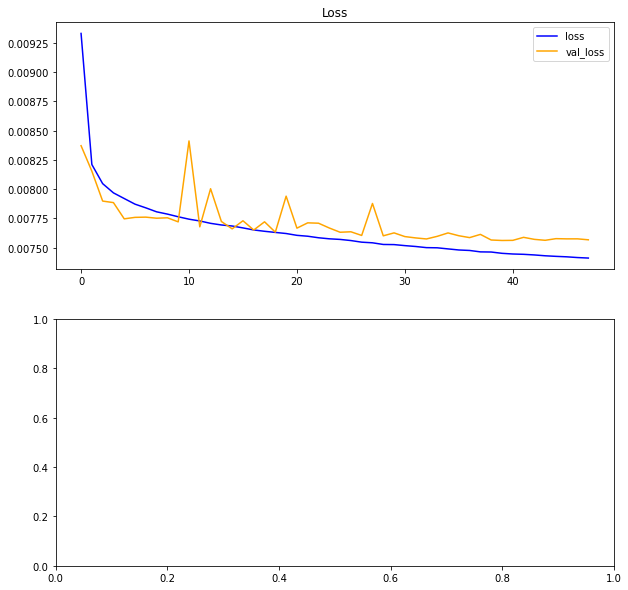

Accuracy: mean=75.395 std=0.000, n=1


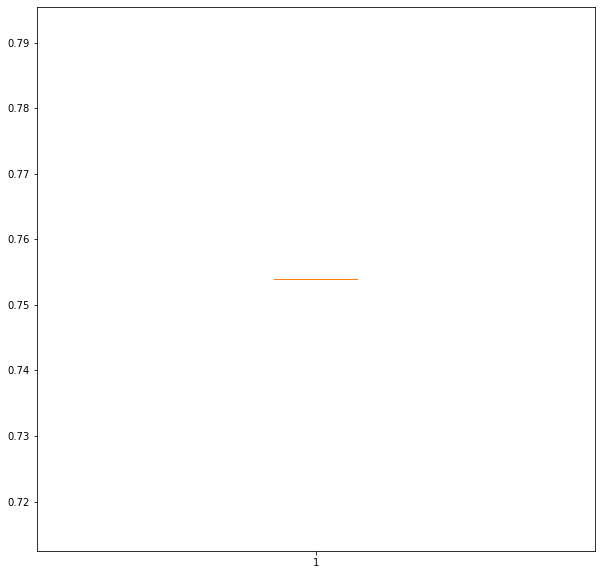

Scores:  [0.7539540529251099]


In [20]:
# learning curves
print(histories[0].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Load saved model

In [21]:
#load model

def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)

if itype=="bveto":
        aa = "bveto"
else:
        aa="btag"
aux = '/eos/user/w/wolter/public/jkrzysiak/model_lowlevMTtot_absw_'+aa+"_"+str(len(models)-1)+'.h5'
### MWMW skip loading models
### models = []
### model=tf.keras.models.load_model(aux, custom_objects={'lr':lr})
### models.append(model)
len(models)


1

Find the roc curve

In [22]:
def binary_clf_curve(y_true, y_score, pos_label=None, sample_weight=None):
    """Calculate true and false positives per binary classification threshold.
    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        True targets of binary classification.
    y_score : ndarray of shape (n_samples,)
        Estimated probabilities or output of a decision function.
    pos_label : int or str, default=None
        The label of the positive class.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    Returns
    -------
    fps : ndarray of shape (n_thresholds,)
        A count of false positives, at index i being the number of negative
        samples assigned a score >= thresholds[i]. The total number of
        negative samples is equal to fps[-1] (thus true negatives are given by
        fps[-1] - fps).
    tps : ndarray of shape (n_thresholds,)
        An increasing count of true positives, at index i being the number
        of positive samples assigned a score >= thresholds[i]. The total
        number of positive samples is equal to tps[-1] (thus false negatives
        are given by tps[-1] - tps).
    thresholds : ndarray of shape (n_thresholds,)
        Decreasing score values.
    """
    # MWMW !!!!!!!!!!!!!!!!
    # replace all negative weights with 0
    #sample_weight[sample_weight<0] = 0


    # make y_true a boolean vector
    y_true = (y_true == 1)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    if sample_weight is not None:
        weight = sample_weight[desc_score_indices]
    else:
        weight = 1.

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    #print weights < 0
    #for i in range(0,len(weight)):
    #  if weight[i]<0:
    #    print("Neg.weight ",i,"  ",weight[i])

    # accumulate the true positives with decreasing threshold
    #from sklearn.utils.extmath import stable_cumsum
    #tps = stable_cumsum(y_true * weight)[threshold_idxs]
    tps = np.cumsum(y_true * weight)[threshold_idxs]
    if sample_weight is not None:
        # express fps as a cumsum to ensure fps is increasing even in
        # the presence of floating point errors
        #fps = stable_cumsum((1 - y_true) * weight)[threshold_idxs]
        fps = np.cumsum((1 - y_true) * weight)[threshold_idxs]
    else:
        fps = 1 + threshold_idxs - tps
  
    # Add an extra threshold position
    # to make sure that the curve starts at (0, 0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    threshold_idxs = np.r_[threshold_idxs[0] + 1, threshold_idxs]

    return fps/fps[-1], tps/tps[-1], y_score[threshold_idxs]

Calculate AUC

In [23]:
def getAuc(x, y):
    """Compute Area Under the Curve (AUC) using the trapezoidal rule.
    This is a general function, given points on a curve.  For computing the
    area under the ROC-curve, see :func:`roc_auc_score`.  For an alternative
    way to summarize a precision-recall curve, see
    :func:`average_precision_score`.
    Parameters
    ----------
    x : ndarray of shape (n,)
        x coordinates. These must be either monotonic increasing or monotonic
        decreasing.
    y : ndarray of shape, (n,)
        y coordinates.
    Returns
    -------
    auc : float
    See Also
    --------
    roc_auc_score : Compute the area under the ROC curve.
    average_precision_score : Compute average precision from prediction scores.
    precision_recall_curve : Compute precision-recall pairs for different
        probability thresholds.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn import metrics
    >>> y = np.array([1, 1, 2, 2])
    >>> pred = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    >>> metrics.auc(fpr, tpr)
    0.75
    """
    from sklearn.utils import check_consistent_length
    from sklearn.utils import column_or_1d, check_array
    from decimal import Decimal



    check_consistent_length(x, y)
    x = column_or_1d(x)
    y = column_or_1d(y)

    if x.shape[0] < 2:
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % x.shape)

    direction = 1
    dx = np.diff(x)

    if np.count_nonzero(dx>=0) < np.count_nonzero(dx<=0):
      direction = -1

    # remove elements with diff<=0 
    #x=np.delete(x,np.nonzero(direction*dx <= 0))
    #y=np.delete(y,np.nonzero(direction*dx <= 0))
    #dx=np.delete(dx,np.nonzero(direction*dx <= 0))  
    #print("dx<0 indices are ", np.nonzero(dx <= 0),np.array((np.nonzero(dx <= 0))).shape,dx[dx<=0]) 

    area = direction * np.trapz(y, x)
    print("getAuc area & max(y): ",area,np.max(y))
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in np.trapz do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area

Build an ensamble of networks trained using k-folding and test it on test data

---



In [24]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #Limit the number of events
  #n_events = 100000
  #x_test_all, y_test_all, sw_test_all = x_test_all[0:n_events], y_test_all[0:n_events], sw_test_all[0:n_events]


  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  np_y_test_all = y_test_all.to_numpy()
  np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()



  # normalize test data
  ### MWMW skip normalization
  ### np_x_test_all = np.array(layer(np_x_test_all))
  ### np_x_test_all_s = np.array(layer(np_x_test_all_s))
  ### np_x_test_all_b = np.array(layer(np_x_test_all_b))

  print("MWMW ",np_x_test_all.shape)
  print("MWMW ",np_x_test_all_s.shape)
  print("MWMW ",np_x_test_all_b.shape)

  # make predictions
  yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  # replace negative values by zero
  #summed[summed<0] = 0
  #summed_s[summed_s<0] = 0
  #summed_b[summed_b<0] = 0
  
  # func to calculate auc

  fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all, drop_intermediate=False)
  #fpr, tpr, tresholds = binary_clf_curve(np_y_test_all, summed, sample_weight=np_sw_test_all)

  print("Number of ROC thresholds: ", tresholds.shape)
  r_auc = getAuc(fpr,tpr)
  print('auc = ',r_auc)


  #m = tf.keras.metrics.AUC(num_thresholds=1000)
  #m.update_state(np_y_test_all, summed, sample_weight=np_sw_test_all)
  #r_auc = m.result().numpy()
  #print("r_auc (ensamble) == ",r_auc)

  aucs = []
  for i in range(len(models)):
    yyhats = models[i].predict(np_x_test_all)[:,0]
    #m.update_state(np_y_test_all, yyhats, sample_weight=np_sw_test_all)
    #aucs.append(m.result().numpy())
    fpr, tpr, tresholds = roc_curve(np_y_test_all, yyhats, sample_weight=np_sw_test_all, drop_intermediate=True)
    #fpr, tpr, tresholds = binary_clf_curve(np_y_test_all, yyhats, sample_weight=np_sw_test_all)

    aucs.append(getAuc(fpr,tpr))


  av_auc = np.mean(aucs)

  

  #plot roc
  plt.figure(figsize=(6,4))
  plt.plot(1-fpr[tpr>0.50],tpr[tpr>0.50])
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  summed = summed.reshape((len(summed),1))
  summed_s = summed_s.reshape((len(summed_s),1))
  summed_b = summed_b.reshape((len(summed_b),1))

  
  plt.figure(figsize=(6,4))
  plt.hist(summed_s, weights=np_sw_test_all_s, bins=200, label="Signal",log=True, alpha=0.5, histtype='stepfilled')  
  plt.hist(summed_b, weights=np_sw_test_all_b, bins=200, label="Bckg.",log=True, alpha=0.5, histtype='stepfilled')
  plt.ylim(bottom=0.01)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  
  plt.figure(figsize=(6,4))
  plt.hist(summed_s, weights=np_sw_test_all_s, bins=200, label="Signal",log=False, alpha=0.5, histtype='stepfilled')  
  plt.hist(summed_b, weights=np_sw_test_all_b, bins=200, label="Bckg.",log=False, alpha=0.5, histtype='stepfilled')
  plt.ylim(bottom=0)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  return r_auc, av_auc, aucs

Test accuracy

In [25]:
def accuracy_ensamble(x_test_all, y_test_all, sw_test_all):

  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  #np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  #np_y_test_all = y_test_all.to_numpy()
  #np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()

  np_sw_test_all_s = np_sw_test_all_s.reshape((len(np_sw_test_all_s)))
  np_sw_test_all_b = np_sw_test_all_b.reshape((len(np_sw_test_all_b)))

  # normalize test data
  #np_x_test_all = np.array(layer(np_x_test_all))
  #np_x_test_all_s = np.array(layer(np_x_test_all_s))
  #np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  #yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  #summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  cut=0.5
  summed_s[summed_s>cut] = 1
  summed_s[summed_s<cut] = 0
  summed_b[summed_b>cut] = 1
  summed_b[summed_b<cut] = 0

  isummed_s = summed_s.astype(np.int32)
  isummed_b = summed_b.astype(np.int32)

  

  false_neg, true_pos = np.bincount(isummed_s, weights=np_sw_test_all_s)
  #false_neg=np.bincount((1-isummed_s), weights=np_sw_test_all_s)
  true_neg, false_pos = np.bincount(isummed_b, weights=np_sw_test_all_b)
  #false_pos=np.bincount((1-isummed_b), weights=np_sw_test_all_b)

  #print("true_pos = ",true_pos)
  #print("false_neg = ",false_neg)
  #print("true_neg = ",true_neg)
  #print("false_pos = ",false_pos)

  sensitivity = true_pos / (true_pos+false_neg)
  specificity = true_neg / (true_neg+false_pos)
  accuracy    = (true_pos + true_neg)/(true_pos + true_neg + false_neg + false_pos)

  print("accuracy = ",accuracy,", specificity = ", specificity,", sensitivity = ", sensitivity)

  return accuracy, specificity, sensitivity

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
49924  -0.383115 -0.224661 -0.610623 -0.217863  -0.107465 -0.518695 -0.436352   
98898  -0.443115 -0.491917 -0.521503  0.535667   0.467916 -0.271756  0.994167   
7375   -0.648214 -0.611217 -0.579314 -0.493506  -0.801182 -0.049237  1.824153   
145751  0.732572  0.691515  0.207415  0.901528  -0.047314  0.038111 -1.089047   
102477 -0.457749 -0.505032 -0.599271  0.380470   1.396925 -0.641631 -1.052654   
...          ...       ...       ...       ...        ...       ...       ...   
26970  -0.173570 -0.248575 -0.601217  0.572579  -0.128914  0.383360  2.166434   
1715   -0.873033 -0.777220 -0.646715 -0.884107  -0.713836 -0.728014 -0.481615   
10152  -0.618596 -0.726263 -0.520733 -0.229391   0.029615 -0.682698 -0.603519   
94840   0.262227  0.167799  0.723502 -0.440139   0.251794  0.077744 -0.636577   
14390  -0.210516 -0.044781 -0.209942 -0.178863   0.404506 -0.066605  0.502280   

      

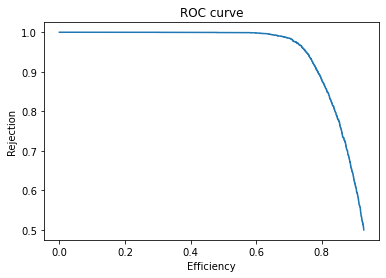

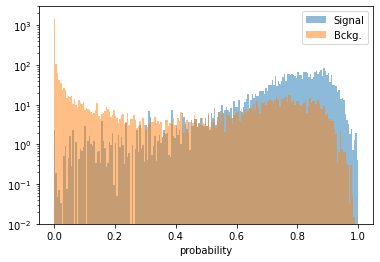

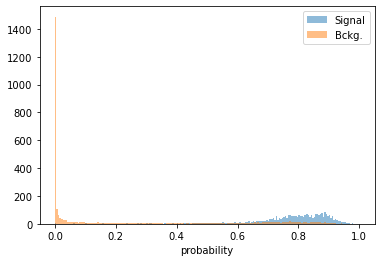

-------------------------------------------
signal_mass =  250.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
5300   -0.655213 -0.709327 -0.382112 -0.606056  -0.607638 -0.658052 -1.047041   
33457  -0.122350 -0.347265  0.188883 -0.062853  -0.193836 -0.314082 -0.762674   
138853  0.064400  0.052959 -0.696075  0.910107  -0.578809 -0.471740 -0.342888   
123734 -0.647703 -0.615376 -0.677121 -0.382176  -0.957850 -0.454232  0.858030   
31474  -0.446873 -0.315836 -0.467183 -0.110307  -0.161202 -0.484874 -0.409678   
...          ...       ...       ...       ...        ...       ...       ...   
119271  2.746697  2.746128  2.740075  0.894414   1.956095  3.439951  1.149538   
2294    0.315702  0.318379 -0.073122  0.497645   0.214810 -0.154076 -0.683837   
5547   -0.768491 -0.758715 -0.422025 -0.874909  -0.785956 -0.652687 -0.544746   
115475  1.094485  2.005435 -0.097720  1.257860   2.835254  0.231988 -0.874638   
92618  -0.213639 -0.202980 -0.677801  0.4113

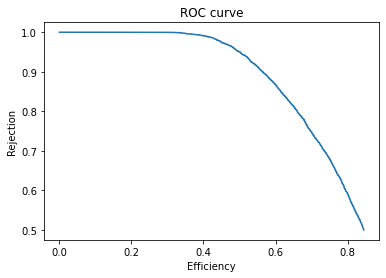

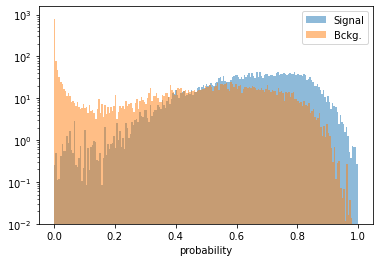

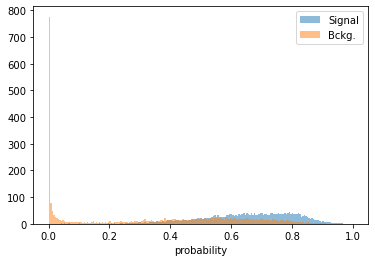

-------------------------------------------
signal_mass =  300.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
87168   0.008556 -0.005028 -0.139892  0.101611   0.120310 -0.317656 -1.233615   
69418  -0.442578 -0.437867 -0.417499 -0.327695  -0.763326 -0.524972 -0.521841   
24617  -0.306037 -0.304626  0.175642 -0.857922  -0.237915 -0.312834 -0.929157   
73860   0.273819  0.184831  0.560842 -0.171741   0.221985  0.040733 -0.587766   
4883   -0.754051 -0.729003 -0.610866 -0.530435  -0.614378 -0.675518 -0.242508   
...          ...       ...       ...       ...        ...       ...       ...   
131732  0.479584  0.255163  0.052305  1.075826   0.082656  0.468602  1.057239   
143057  0.386462  0.515095  0.109800  0.152870  -0.048788 -0.056680 -1.168774   
17062  -0.697382 -0.674911 -0.561689 -0.594475  -0.957124 -0.552239  0.330136   
8450   -0.087077 -0.045063 -0.213485 -0.025999  -0.331533 -0.353801 -1.216084   
47960  -0.248842 -0.298431  0.260305 -0.7819

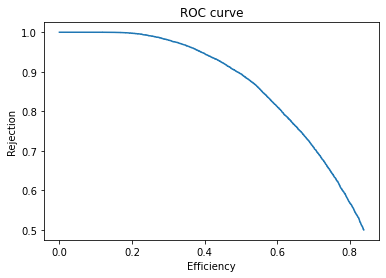

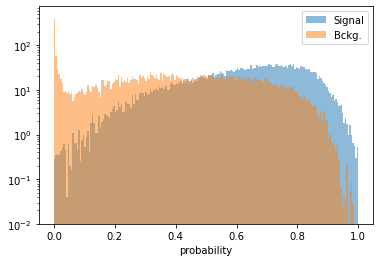

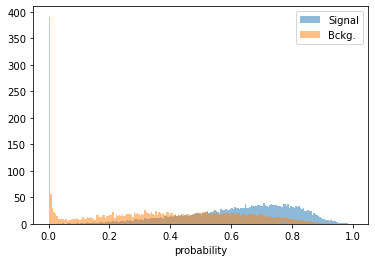

-------------------------------------------
signal_mass =  350.00000000000006
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
119343  0.013819  1.231283 -0.657160  1.555003   1.562181 -0.013947  0.322782   
164949  0.742883  0.638999  0.029465  1.280101  -0.054642  0.003245 -0.558711   
21025  -0.400728 -0.365436 -0.634150 -0.034574  -0.806640 -0.594660 -0.693282   
79596   0.075102  0.131471 -0.657050  0.753592  -0.075321 -0.491764 -1.135526   
70174  -0.508875 -0.469119 -0.408330 -0.517467  -0.786212 -0.566106 -1.199360   
...          ...       ...       ...       ...        ...       ...       ...   
46351  -0.745443 -0.729105 -0.666254 -0.525892  -0.967772 -0.703611 -0.361603   
6103    0.269318 -0.005927  0.575362  0.133700   0.138773  0.046957 -0.156473   
118573 -0.226765 -0.345409 -0.602571  0.612303  -0.542730 -0.567669 -0.563104   
28158  -0.486177 -0.194859 -0.699167  0.384547   0.182895 -0.595300 -1.015525   
10921  -0.391506 -0.379216 -0.5

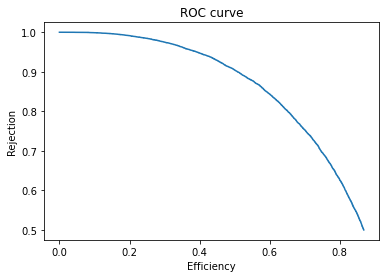

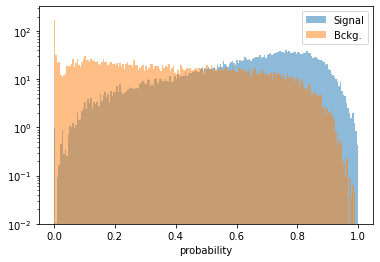

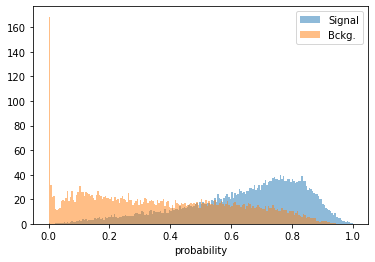

-------------------------------------------
signal_mass =  400.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
109753  3.005899  2.496773  2.186191  3.033168   2.400908  1.975710  0.307288   
64061  -0.792376 -0.712180 -0.482227 -0.963280  -0.740540 -0.478101  0.591833   
1422    0.630749  0.437055  0.714534  0.382723   0.455176  2.264735  2.309563   
109578 -0.151435 -0.161599  0.321954 -0.780965  -0.502408 -0.200206 -0.804590   
45729  -0.374546 -0.374241 -0.073402 -0.656340  -0.701701 -0.186543  0.414046   
...          ...       ...       ...       ...        ...       ...       ...   
22565  -0.546271 -0.538283 -0.170428 -0.829886  -0.721539 -0.474459 -0.484517   
39451  -0.378311 -0.330781  0.049157 -0.899750  -0.440844 -0.167903  0.242626   
3077   -0.113271  0.216477 -0.232383 -0.094553   1.026320 -0.251150 -0.603918   
137815  0.071475  0.035063  0.735451 -0.897560  -0.214923  0.214110  0.115434   
125452  1.172622  1.475735  1.534207 -0.6173

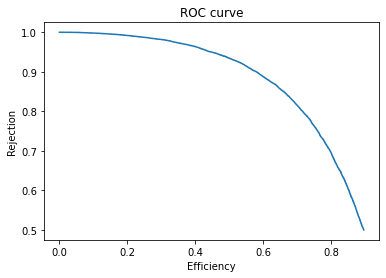

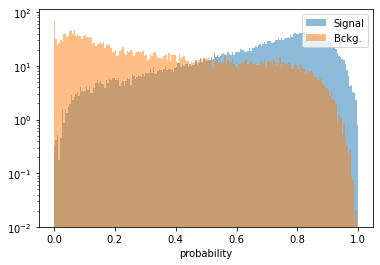

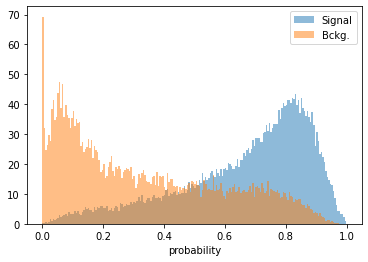

-------------------------------------------
signal_mass =  500.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
35704  -0.439107 -0.561140 -0.196687 -0.236160  -0.374835 -0.268436  0.658682   
131621 -0.470232 -0.486063 -0.557970 -0.149102  -0.732986 -0.444875  0.409144   
137893 -0.666384 -0.562273 -0.648146 -0.579827  -0.782887 -0.607982 -0.118971   
2646   -0.141582  0.551665 -0.300751 -0.765327   0.650395 -0.217395 -1.130018   
93218   0.062266 -0.500507 -0.221957  1.858554   0.209386 -0.425051 -0.073848   
...          ...       ...       ...       ...        ...       ...       ...   
42051  -0.139919 -0.164559  0.028575 -0.348160  -0.383514 -0.312514 -1.098280   
74785   0.273358  0.217916  1.036420 -0.916639   0.154079  0.223263 -0.482279   
55682  -0.115600 -0.102329  0.107915 -0.485401  -0.476606 -0.253706 -0.909601   
52595  -0.504782 -0.534021 -0.723654  0.115201  -0.626320 -0.596571  0.135942   
70816   0.107719  0.288544 -0.213907  0.0817

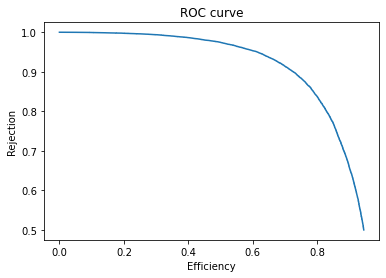

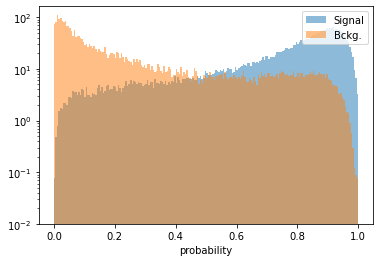

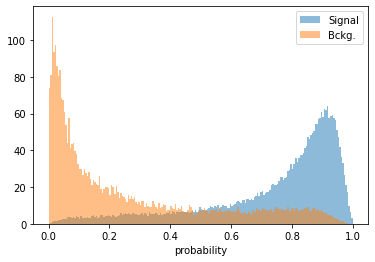

-------------------------------------------
signal_mass =  600.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
150495  0.772192  0.775234  1.275617 -0.501186   0.488690  0.503593 -0.609968   
58230  -0.688841 -0.592336 -0.426241 -0.822087  -0.523652 -0.444460  0.395205   
70450  -0.577078 -0.471720 -0.605727 -0.250286   0.390313  0.345172  2.373431   
54048  -0.101192 -0.017456 -0.633469  0.393290  -0.205357 -0.507402 -0.826693   
105293  1.353488  1.955307  1.345638 -0.362352   2.046668  0.923352 -0.712199   
...          ...       ...       ...       ...        ...       ...       ...   
89913   0.621482  1.352382  0.303777 -0.448890   1.121633  0.371800 -0.376579   
38196  -0.505025 -0.374992 -0.268678 -0.841453  -0.486355 -0.407001 -0.229342   
136819 -0.691481 -0.709423 -0.520124 -0.560889  -0.722728 -0.692124 -1.227142   
13632  -0.578033 -0.701999 -0.494352  0.043387   0.197454 -0.636084 -0.367067   
8637    0.085896 -0.340590 -0.512893  1.8099

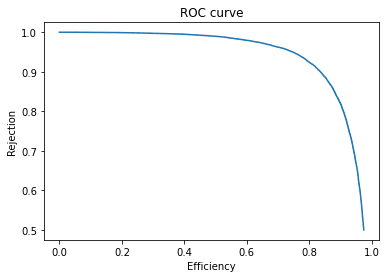

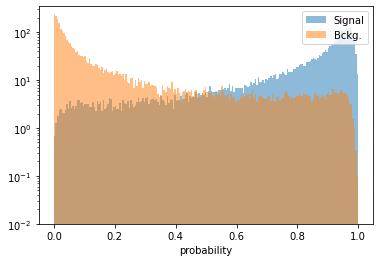

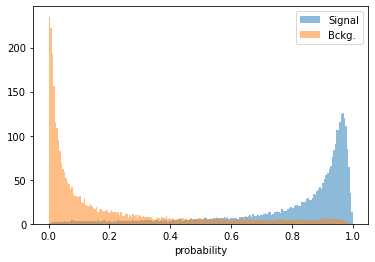

-------------------------------------------
signal_mass =  700.0000000000001
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
106250  0.093522  0.057115  0.446462 -0.484686  -0.335418 -0.091655 -1.030625   
12685  -0.194450 -0.554449 -0.479705  1.319351   1.773915 -0.502080  0.120632   
74356   1.008439  0.766065  0.894050  0.891134   0.454757  0.981338  0.765910   
104132 -0.211808 -0.361879  0.097474 -0.214473  -0.378541  0.002892  0.761713   
13709  -0.225537 -0.243114  0.073708 -0.563510  -0.283367 -0.165865  0.065312   
...          ...       ...       ...       ...        ...       ...       ...   
70789   0.179902  0.099133  0.722526 -0.592263   0.849607  0.005332 -1.083820   
15411   0.302556  0.468584 -0.356061  0.588274   0.109989 -0.183984 -0.322237   
107835  1.669557  2.245068  2.097539 -0.797132   2.551145  4.296475  1.986792   
115336 -0.101531 -0.006335  0.137013 -0.598572   0.375883  0.158046  0.616458   
162096 -0.167165 -0.231877 -0.06

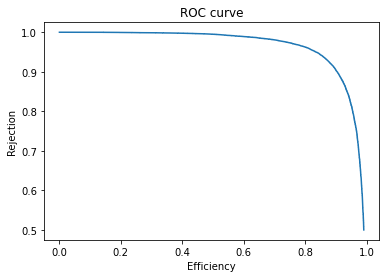

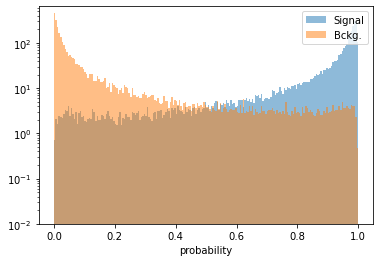

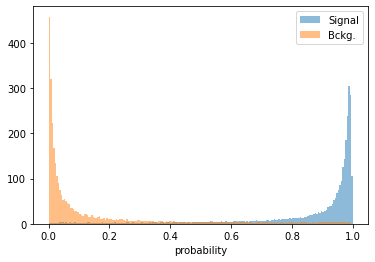

-------------------------------------------
signal_mass =  800.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
4245    0.138211  0.105214  0.464180 -0.424242   0.032556  0.434035  0.766125   
156908  0.333398  0.255404  0.517257 -0.087689  -0.012255  0.162847 -0.116656   
113189 -0.445976 -0.420665 -0.576101 -0.166269  -0.729565 -0.607073 -1.077104   
93426   0.038268  0.005466  0.542682 -0.709174  -0.193224 -0.028607 -0.528864   
95581   0.594319  0.528221  1.140744 -0.499637   0.336124  0.806980  0.522535   
...          ...       ...       ...       ...        ...       ...       ...   
148279 -0.749161 -0.781704 -0.714450 -0.363005  -0.736361 -0.755002 -0.533413   
36194   0.211018  0.200979  0.219408  0.058400   0.111775 -0.076129 -0.581056   
110308  0.350851  0.418193  0.546865 -0.334788   0.169277  0.528336  0.576075   
42225  -0.744866 -0.765526 -0.613709 -0.524064  -0.852692 -0.725972 -0.559301   
113807  0.494634 -0.565661 -0.553011  5.7602

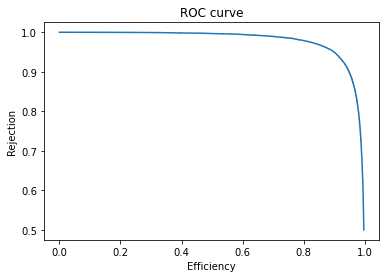

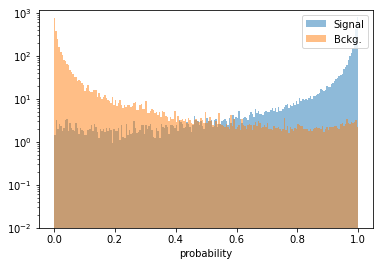

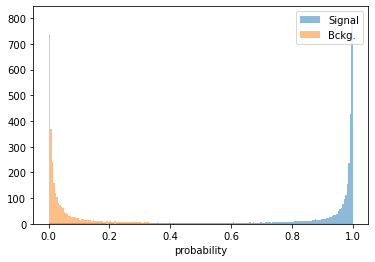

-------------------------------------------
signal_mass =  1000.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
94037  -0.004286 -0.000498  0.482982 -0.715179   0.027522 -0.045209 -0.463841   
128163  0.354820  0.280203  1.108718 -0.839034  -0.004466  0.187624 -1.214114   
36122  -0.553807 -0.499201 -0.200291 -0.891974  -0.692660 -0.412751 -0.105969   
132722  0.101844  0.062328 -0.348177  0.573738  -0.539797 -0.370214 -1.066332   
32203  -0.437784 -0.355962 -0.723135 -0.061910  -0.651141 -0.646738 -1.090320   
...          ...       ...       ...       ...        ...       ...       ...   
15547  -0.727672 -0.629120 -0.439677 -0.932339  -0.257256 -0.537779 -0.000258   
97583   0.881776  0.924751  0.361491  0.835894   0.440506  0.169218 -0.965085   
15111   0.555535  0.678885  0.835056 -0.394722   0.631289  0.252789 -1.155410   
92466   0.357367  0.146564  0.785391 -0.106701   0.108232  0.889699  1.203492   
111902 -0.304169 -0.292851  0.169677 -0.877

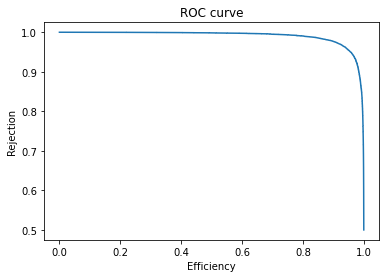

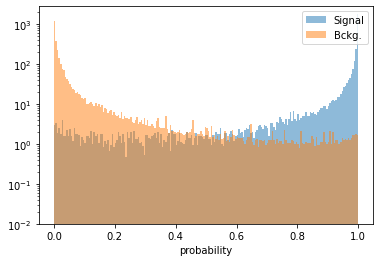

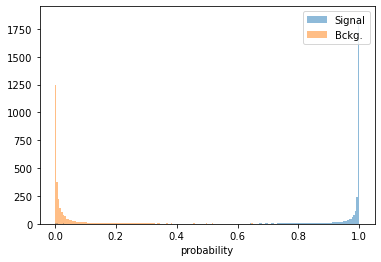

-------------------------------------------
signal_mass =  1200.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
121695 -0.087900 -0.179772  0.433798 -0.657702  -0.104502  0.284632  0.820768   
49150   0.071266 -0.237603 -0.048674  0.795393  -0.233087 -0.363989 -1.188442   
14322  -0.701373 -0.697988 -0.370129 -0.816365  -0.600044 -0.597643 -0.409474   
96969  -0.314443  0.020623 -0.438792 -0.428633   0.381653 -0.126622  0.600209   
24637  -0.177905 -0.245878 -0.190467 -0.002709  -0.332101  0.856818  2.291102   
...          ...       ...       ...       ...        ...       ...       ...   
21628  -0.800372 -0.778864 -0.469108 -0.888050  -0.711914 -0.636002 -0.153464   
16742  -0.744579 -0.805992 -0.622229 -0.381288  -0.198293  0.252148  2.769535   
71867   1.973069  1.891464  2.197547  0.454099   1.307669  1.464774 -0.099148   
99290  -0.202901 -0.423859  0.047757  0.000086   0.099963 -0.074745  0.687270   
11749  -0.719139 -0.781622 -0.491855 -0.509

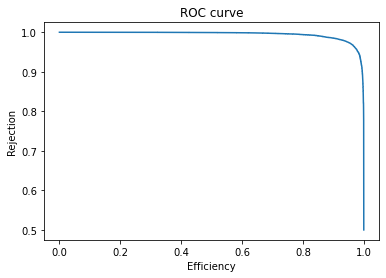

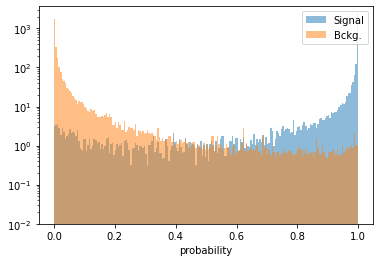

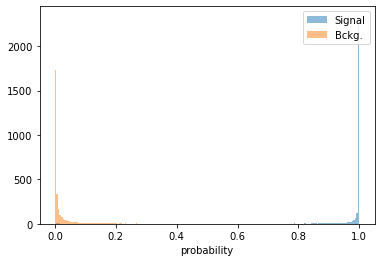

-------------------------------------------
signal_mass =  1500.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
157603 -0.374169 -0.395907 -0.309975 -0.290852  -0.489263 -0.389443 -0.005237   
109890 -0.038103 -0.086589  0.480867 -0.723725  -0.395563 -0.141104 -1.088074   
45562  -0.248101 -0.217558 -0.461985  0.122188  -0.380647  1.762077  3.406877   
150689 -0.788376 -0.793582 -0.690558 -0.521835  -0.774485 -0.774336 -1.179151   
62145  -0.541349 -0.513525 -0.486218 -0.447026  -0.795914 -0.517500 -0.075576   
...          ...       ...       ...       ...        ...       ...       ...   
7359    4.299369  4.109751  2.547770  4.115726   3.123521  2.216817 -0.397209   
31586  -0.270570 -0.286175 -0.514658  0.141408  -0.236626 -0.477814 -0.286865   
19614   3.085501  2.881018  1.205858  4.023365   2.043719  1.062808 -1.010158   
73080   0.761170  0.620099  1.098262 -0.020769   0.163879  2.806795  2.343559   
25894   1.505412  2.576899  0.244298  0.899

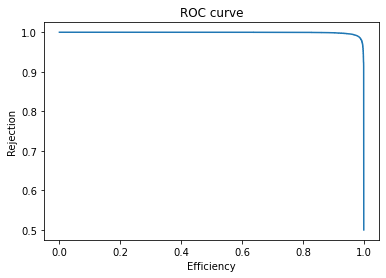

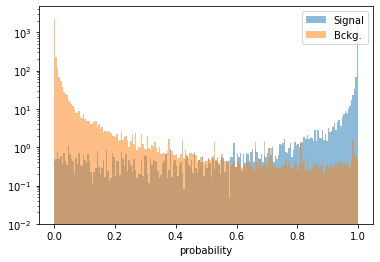

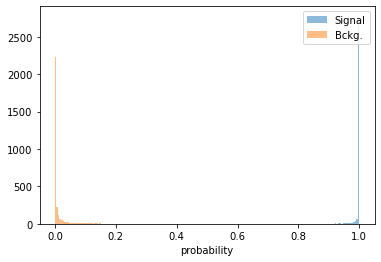

-------------------------------------------
signal_mass =  2000.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
1139   -0.731432 -0.690853 -0.433619 -0.858235  -0.941055 -0.573810 -0.078425   
20812   2.263708  2.278078  2.702454  0.134566   1.732757  1.656336 -0.372334   
7647   -0.639986 -0.549909 -0.727908 -0.255364  -0.582052 -0.609531  0.101497   
135286 -0.523685 -0.629457 -0.380021 -0.296040  -0.676972 -0.580255 -0.379596   
31680  -0.543053 -0.537305 -0.370107 -0.524424  -0.508711 -0.573559 -1.013050   
...          ...       ...       ...       ...        ...       ...       ...   
12572   0.736158  0.357230  1.123109  0.585463   1.257888  0.514781  0.139398   
26401   4.818927  5.100160  1.436538  5.720028   3.915674  1.726154 -1.188711   
91572  -0.245232 -0.270462 -0.043298 -0.429576  -0.537179 -0.365086 -0.929289   
104576  0.329548  0.322126  0.974954 -0.837138   0.010303  0.213573 -0.671320   
155962 -0.033746 -0.213267  0.038653  0.144

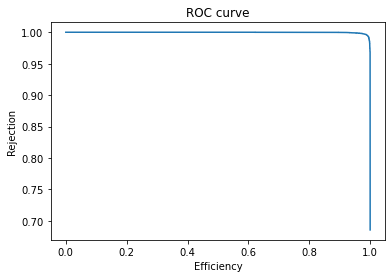

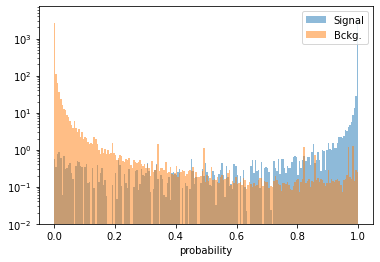

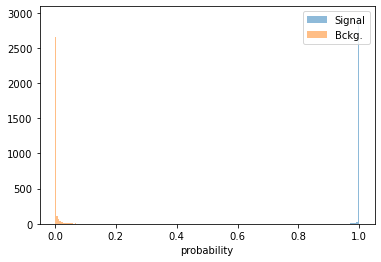

-------------------------------------------
signal_mass =  2500.0
           mTtot   tau_pt0   tau_pt1   MET_met  MET_SumET      mvis  deltaEta  \
16755   2.208943  2.154078  0.832095  2.577785   0.981044  1.766920  0.980743   
12151  -0.529316 -0.770526 -0.683157  0.591222   0.113973 -0.756842 -0.848951   
13561  -0.660249 -0.534958 -0.702591 -0.519916  -0.721037 -0.642781 -0.302825   
82655  -0.129474 -0.157823  0.392663 -0.800765  -0.446728 -0.010207  0.074448   
31165  -0.672037 -0.540327 -0.586772 -0.684451  -0.628272 -0.622570 -0.533517   
...          ...       ...       ...       ...        ...       ...       ...   
5143    6.366148  5.876956  1.510272  9.444974   2.662370  1.976972 -0.909280   
158018 -0.553243 -0.443512 -0.368214 -0.760673  -0.537608 -0.452340 -0.115314   
149184 -0.745323 -0.823081 -0.721272 -0.160153  -0.647441 -0.684580  0.304575   
9499   -0.745051 -0.584115 -0.671698 -0.735804   0.281723 -0.555177  0.326519   
149497 -0.547333 -0.492624 -0.356221 -0.678

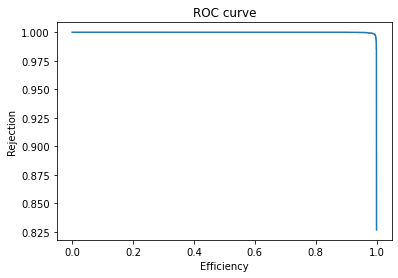

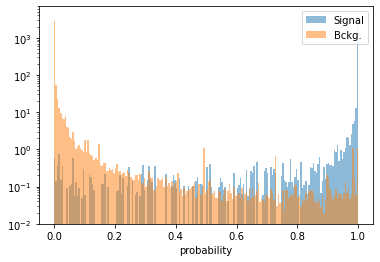

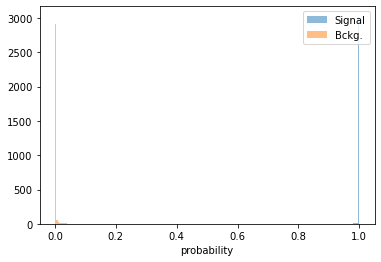

-------------------------------------------


In [26]:
auc_list = []
av_auc_list = []
aucs_list = []

acc_list = []
spec_list = []
sens_list = []

for m in np.divide(masses, 10000.) :  #masses:  # divide mass by 10000


  print("signal_mass = ",m*10000.)
  #print("signal_mass = ",m)
    
  if datatype == 'lephad':  
   mask = np.in1d(x_test_all.signal_mass, m)
  if datatype == 'hadhad':
   mask = np.in1d(x_test_all.sig_mass, m)

  

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  # WARNING: absolute values of weights!!!
  # sw_test_m = sw_test_all[mask].abs()
  sw_test_m = sw_test_all[mask]  
  # MWMW !!!!!!!!!!!!!!!!
  # replace all negative weights with 0
  # sw_test_m[sw_test_m[mask]<0] = 0  

  #x_test_m = x_train_all[mask]
  #y_test_m = y_train_all[mask]
  #sw_test_m = sw_train_all[mask]

  print(x_test_m)
  print(y_test_m)
  print(sw_test_m)

  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list.append(auc)
  av_auc_list.append(av_auc)
  aucs_list.append(aucs)

  ### MWMW do not calculate accuracy for not normalized data
  # accuracy, specificity, sensitivity = accuracy_ensamble(x_test_m, y_test_m, sw_test_m)
  # acc_list.append(accuracy)
  # spec_list.append(specificity)
  # sens_list.append(sensitivity)
  
  print("-------------------------------------------")


Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

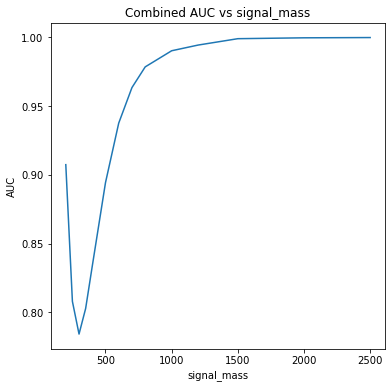

[0.9074412998866996]


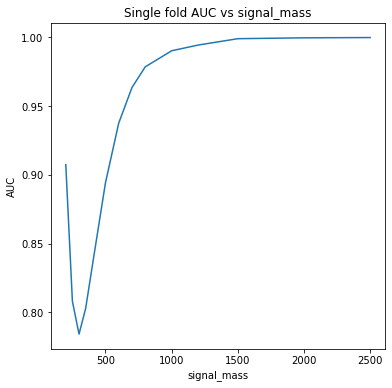

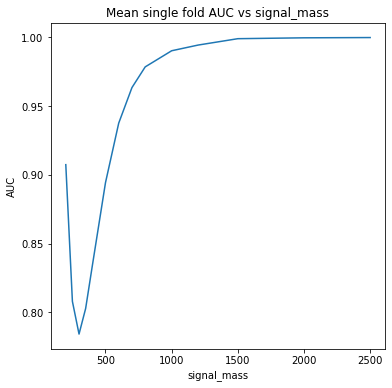

signal_mass  comb. auc  mean auc
0           200   0.907441  0.907441
1           250   0.807932  0.807932
2           300   0.784180  0.784180
3           350   0.802785  0.802785
4           400   0.833574  0.833574
5           500   0.894357  0.894357
6           600   0.937677  0.937677
7           700   0.963535  0.963535
8           800   0.978581  0.978581
9          1000   0.990326  0.990326
10         1200   0.994470  0.994470
11         1500   0.999105  0.999105
12         2000   0.999742  0.999742
13         2500   0.999927  0.999927

In [27]:

plt.figure(figsize=(6,6))
plt.plot(masses, np.array(auc_list))
plt.title('Combined AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

print(aucs_list[0])

plt.figure(figsize=(6,6))
for i in range(len(aucs_list[0])):
  aux=[]
  for k in range(len(aucs_list)):
    aux.append(aucs_list[k][i])
  plt.plot(masses, np.array(aux))
plt.title('Single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(av_auc_list))
plt.title('Mean single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

'''
plt.figure(figsize=(6,6))
plt.plot(masses, np.array(acc_list))
plt.title('Accuracy vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(spec_list))
plt.title('Specificity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(sens_list))
plt.title('Sensitivity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()
'''

# Calling DataFrame constructor after zipping 
# both lists, with columns specified 

### MWMW for not normalized data do not use accuracy etc
### aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list, acc_list, spec_list, sens_list)), 
###               columns =['signal_mass', 'comb. auc', 'mean auc']) 
aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list)), 
               columns =['signal_mass', 'comb. auc', 'mean auc'])
aucf

Stop program execution

In [28]:
import sys
sys.exit()

SystemExit: 

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Split test data according to signal_mass, than train and test a network separately for each subsample. 

In [ ]:
# Set the save_flag to Fals, i.e. no model saving
save_flag = False

signal_mass =  200.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
1913/1913 [==============================] - 20s 9ms/step - loss: 0.0151 - val_loss: 0.0132 - lr: 1.0000e-04
Epoch 2/200
1913/1913 [==============================] - 9s 5ms/step - loss: 0.0130 - val_loss: 0.0146 - lr: 9.6000e-05
Epoch 3/200
1913/1913 [==============================] - 9s 5ms/step - loss: 0.0126 - val_loss: 0.0129 - lr: 9.2160e-05
Epoch 4/200
1913/1913 [==============================] - 10s 5ms/step - loss: 0.0125 - val_loss: 0.0126 - lr: 8.8474e-05
Epoch 5/200
1913/1913 [==============================] - 9s 5ms/step - loss: 0.0122 - val_loss: 0.0123 - lr: 8.4935e-05
Epoch 6/200
1913/1913 [==============================] - 9s 5ms/step - loss: 0.0121 - val_loss: 0.0125 - lr: 8.1537e-05
Epoch 7/200
1913/1913 [==============================] - 9s 5ms/step - loss: 0.0121 - val_loss: 0.0122 - lr: 7.8276e-05
Epoch 8/200
1913/

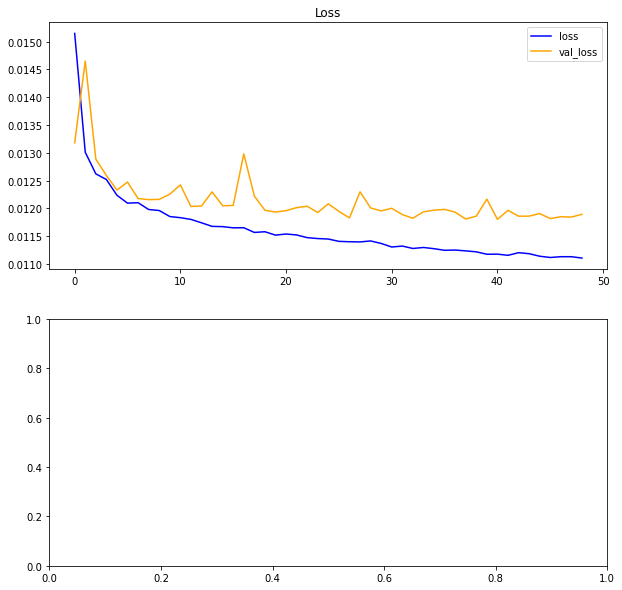

Accuracy: mean=27.316 std=0.000, n=1


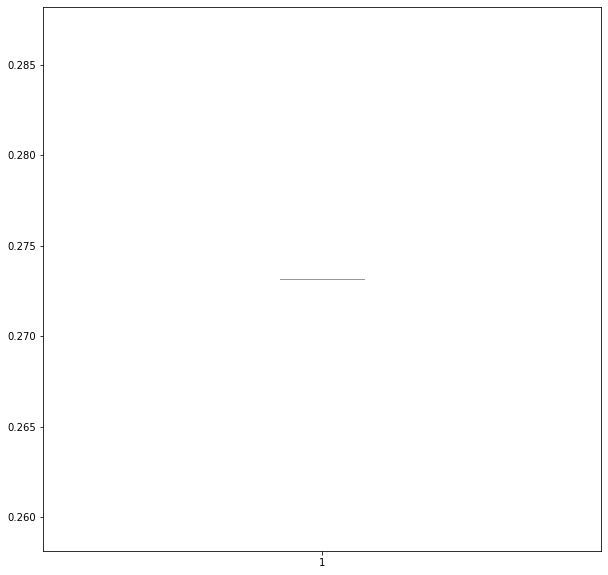

Scores:  [0.27315574884414673]
MWMW  (181089, 11)
MWMW  (6769, 11)
MWMW  (174320, 11)
Number of ROC thresholds:  (180249,)
getAuc area & max(y):  0.9077442089813991 1.0
auc =  0.9077442089813991
getAuc area & max(y):  0.9077442089813993 1.0


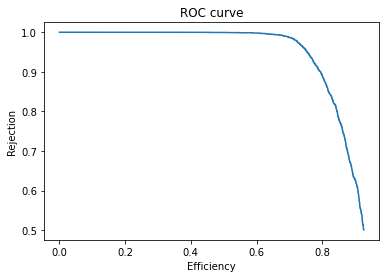

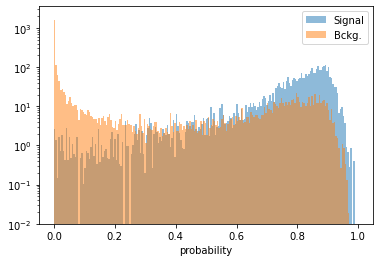

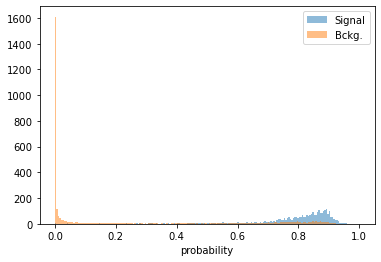

signal_mass =  250.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2060/2060 [==============================] - 22s 10ms/step - loss: 0.0176 - val_loss: 0.0166 - lr: 1.0000e-04
Epoch 2/200
2060/2060 [==============================] - 10s 5ms/step - loss: 0.0165 - val_loss: 0.0164 - lr: 9.6000e-05
Epoch 3/200
2060/2060 [==============================] - 10s 5ms/step - loss: 0.0162 - val_loss: 0.0161 - lr: 9.2160e-05
Epoch 4/200
2060/2060 [==============================] - 10s 5ms/step - loss: 0.0161 - val_loss: 0.0162 - lr: 8.8474e-05
Epoch 5/200
2060/2060 [==============================] - 10s 5ms/step - loss: 0.0160 - val_loss: 0.0160 - lr: 8.4935e-05
Epoch 6/200
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0159 - val_loss: 0.0162 - lr: 8.1537e-05
Epoch 7/200
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0159 - val_loss: 0.0161 - lr: 7.8276e-05
Epoch 8/200

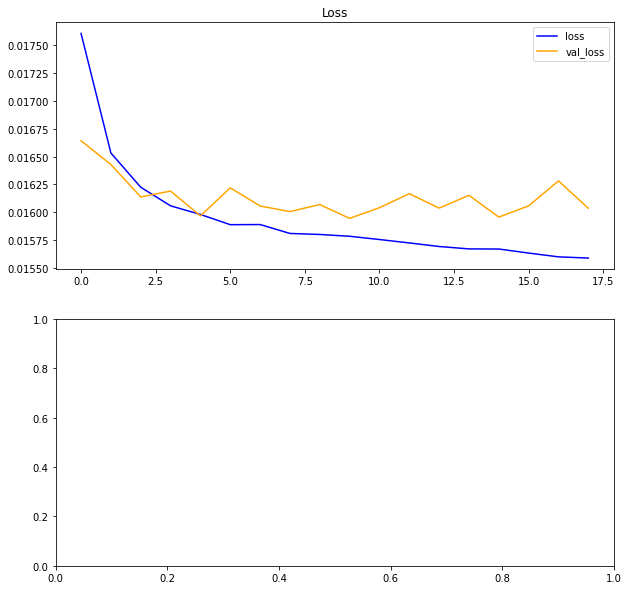

Accuracy: mean=35.327 std=0.000, n=1


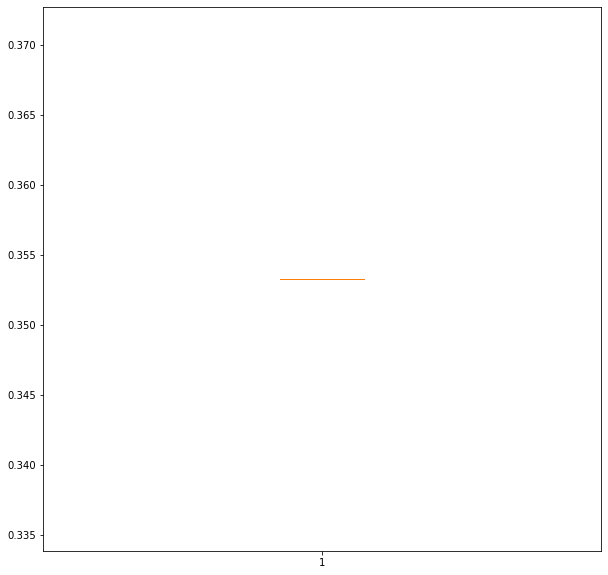

Scores:  [0.35327431559562683]
MWMW  (195628, 11)
MWMW  (20975, 11)
MWMW  (174653, 11)
Number of ROC thresholds:  (194940,)
getAuc area & max(y):  0.8009980151937899 1.0
auc =  0.8009980151937899
getAuc area & max(y):  0.8009980151937895 1.0


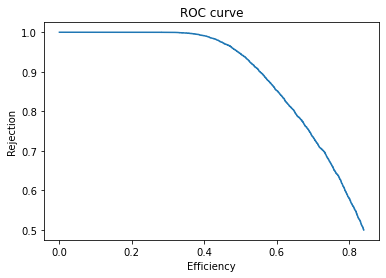

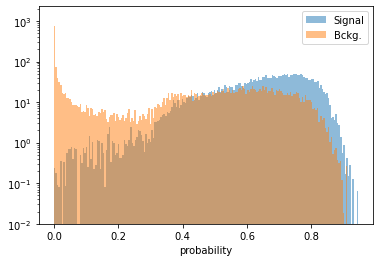

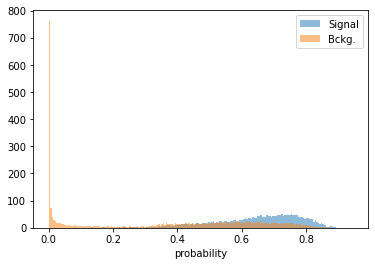

signal_mass =  300.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2233/2233 [==============================] - 22s 9ms/step - loss: 0.0173 - val_loss: 0.0168 - lr: 1.0000e-04
Epoch 2/200
2233/2233 [==============================] - 11s 5ms/step - loss: 0.0162 - val_loss: 0.0165 - lr: 9.6000e-05
Epoch 3/200
2233/2233 [==============================] - 10s 5ms/step - loss: 0.0160 - val_loss: 0.0162 - lr: 9.2160e-05
Epoch 4/200
2233/2233 [==============================] - 10s 5ms/step - loss: 0.0159 - val_loss: 0.0163 - lr: 8.8474e-05
Epoch 5/200
2233/2233 [==============================] - 11s 5ms/step - loss: 0.0159 - val_loss: 0.0161 - lr: 8.4935e-05
Epoch 6/200
2233/2233 [==============================] - 11s 5ms/step - loss: 0.0159 - val_loss: 0.0163 - lr: 8.1537e-05
Epoch 7/200
2233/2233 [==============================] - 10s 5ms/step - loss: 0.0158 - val_loss: 0.0162 - lr: 7.8276e-05
Epoch 8/200


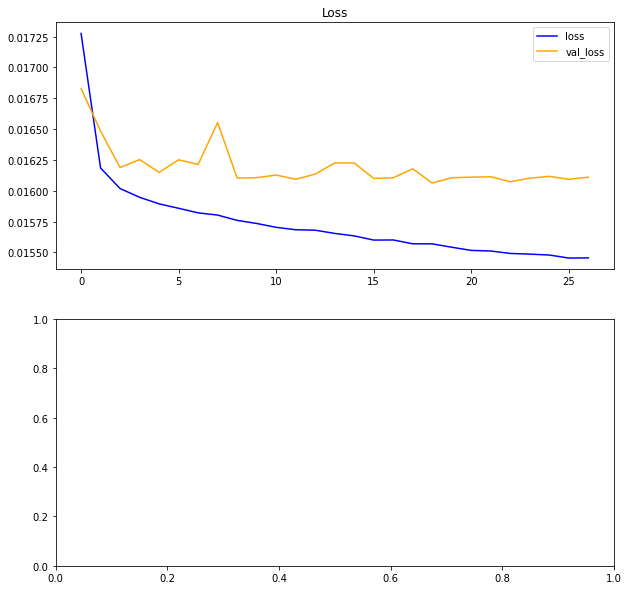

Accuracy: mean=48.556 std=0.000, n=1


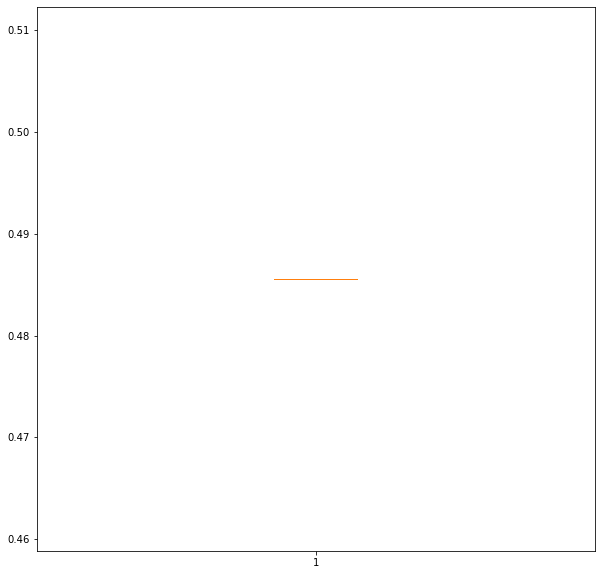

Scores:  [0.4855617880821228]
MWMW  (212160, 11)
MWMW  (37308, 11)
MWMW  (174852, 11)
Number of ROC thresholds:  (211321,)
getAuc area & max(y):  0.7784874441336518 1.0
auc =  0.7784874441336518
getAuc area & max(y):  0.7784874441336519 1.0


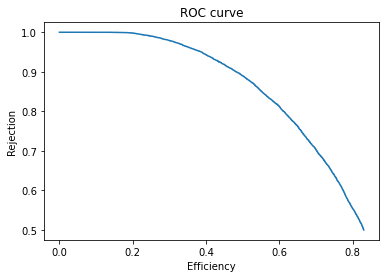

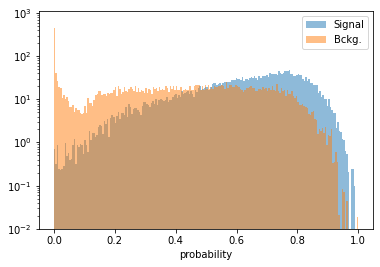

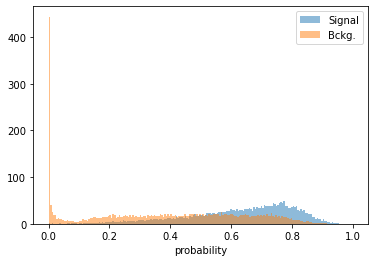

signal_mass =  350.00000000000006
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2378/2378 [==============================] - 26s 9ms/step - loss: 0.0159 - val_loss: 0.0153 - lr: 1.0000e-04
Epoch 2/200
2378/2378 [==============================] - 11s 5ms/step - loss: 0.0151 - val_loss: 0.0149 - lr: 9.6000e-05
Epoch 3/200
2378/2378 [==============================] - 11s 5ms/step - loss: 0.0149 - val_loss: 0.0148 - lr: 9.2160e-05
Epoch 4/200
2378/2378 [==============================] - 11s 5ms/step - loss: 0.0149 - val_loss: 0.0148 - lr: 8.8474e-05
Epoch 5/200
2378/2378 [==============================] - 11s 5ms/step - loss: 0.0148 - val_loss: 0.0147 - lr: 8.4935e-05
Epoch 6/200
2378/2378 [==============================] - 11s 5ms/step - loss: 0.0148 - val_loss: 0.0151 - lr: 8.1537e-05
Epoch 7/200
2378/2378 [==============================] - 11s 5ms/step - loss: 0.0148 - val_loss: 0.0148 - lr: 7.8276e-05

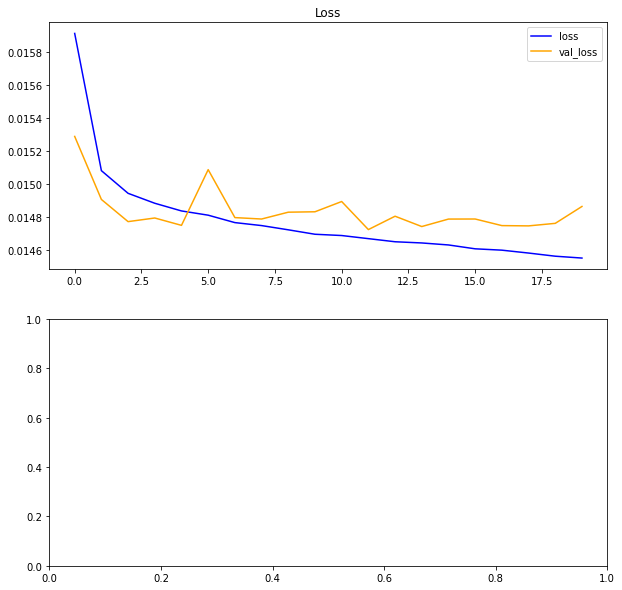

Accuracy: mean=56.873 std=0.000, n=1


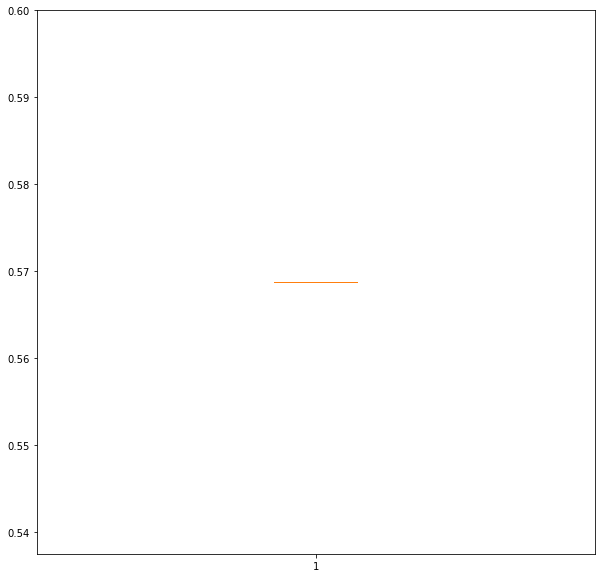

Scores:  [0.5687283277511597]
MWMW  (225391, 11)
MWMW  (50807, 11)
MWMW  (174584, 11)
Number of ROC thresholds:  (223245,)
getAuc area & max(y):  0.7964310166571767 1.0
auc =  0.7964310166571767
getAuc area & max(y):  0.7964310166571765 1.0


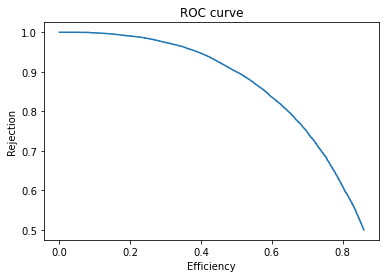

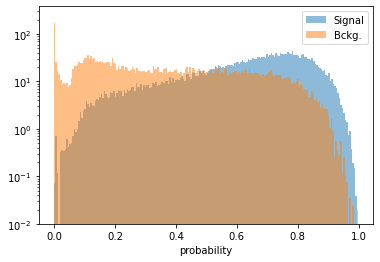

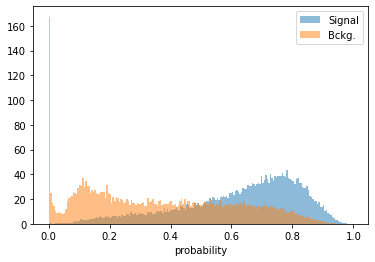

signal_mass =  400.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2494/2494 [==============================] - 25s 10ms/step - loss: 0.0142 - val_loss: 0.0137 - lr: 1.0000e-04
Epoch 2/200
2494/2494 [==============================] - 11s 4ms/step - loss: 0.0136 - val_loss: 0.0137 - lr: 9.6000e-05
Epoch 3/200
2494/2494 [==============================] - 11s 5ms/step - loss: 0.0135 - val_loss: 0.0133 - lr: 9.2160e-05
Epoch 4/200
2494/2494 [==============================] - 11s 4ms/step - loss: 0.0134 - val_loss: 0.0134 - lr: 8.8474e-05
Epoch 5/200
2494/2494 [==============================] - 11s 5ms/step - loss: 0.0134 - val_loss: 0.0134 - lr: 8.4935e-05
Epoch 6/200
2494/2494 [==============================] - 12s 5ms/step - loss: 0.0133 - val_loss: 0.0134 - lr: 8.1537e-05
Epoch 7/200
2494/2494 [==============================] - 12s 5ms/step - loss: 0.0133 - val_loss: 0.0134 - lr: 7.8276e-05
Epoch 8/200

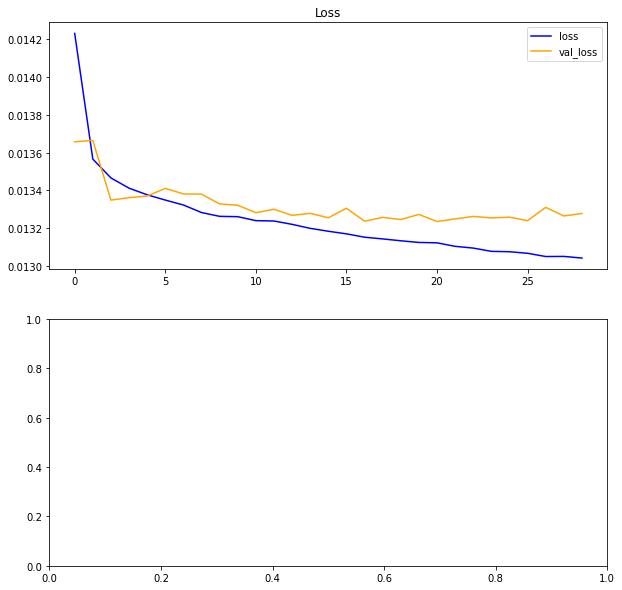

Accuracy: mean=60.205 std=0.000, n=1


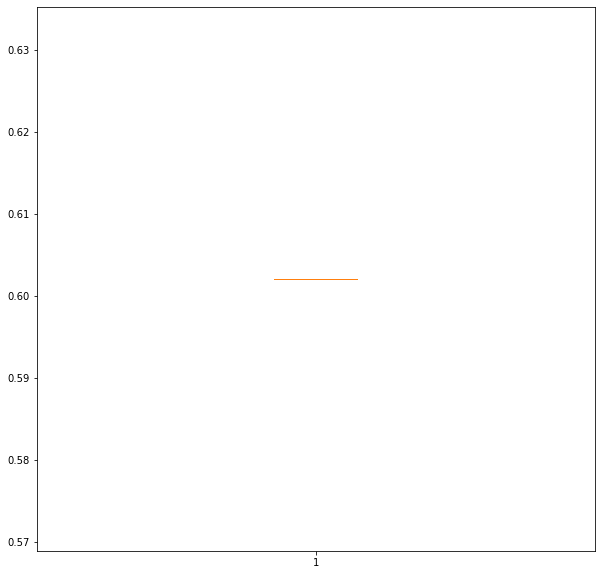

Scores:  [0.6020520329475403]
MWMW  (236991, 11)
MWMW  (62240, 11)
MWMW  (174751, 11)
Number of ROC thresholds:  (235399,)
getAuc area & max(y):  0.829075390226931 1.0
auc =  0.829075390226931
getAuc area & max(y):  0.8290753902269308 1.0


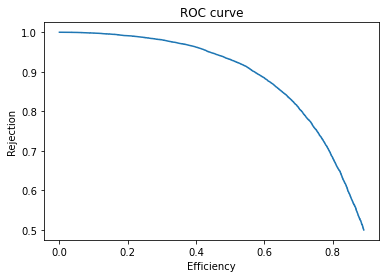

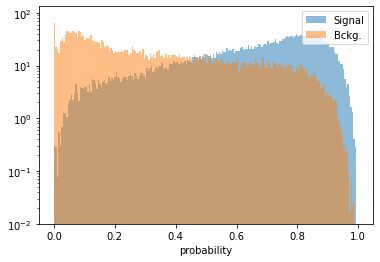

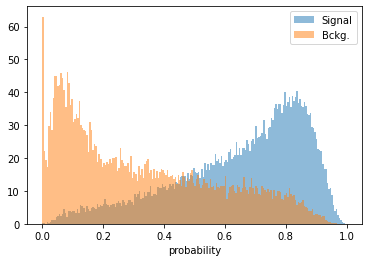

signal_mass =  500.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2649/2649 [==============================] - 26s 9ms/step - loss: 0.0108 - val_loss: 0.0107 - lr: 1.0000e-04
Epoch 2/200
2649/2649 [==============================] - 13s 5ms/step - loss: 0.0103 - val_loss: 0.0102 - lr: 9.6000e-05
Epoch 3/200
2649/2649 [==============================] - 12s 5ms/step - loss: 0.0102 - val_loss: 0.0103 - lr: 9.2160e-05
Epoch 4/200
2649/2649 [==============================] - 12s 5ms/step - loss: 0.0101 - val_loss: 0.0103 - lr: 8.8474e-05
Epoch 5/200
2649/2649 [==============================] - 12s 5ms/step - loss: 0.0101 - val_loss: 0.0103 - lr: 8.4935e-05
Epoch 6/200
2649/2649 [==============================] - 12s 5ms/step - loss: 0.0101 - val_loss: 0.0102 - lr: 8.1537e-05
Epoch 7/200
2649/2649 [==============================] - 12s 5ms/step - loss: 0.0100 - val_loss: 0.0102 - lr: 7.8276e-05
Epoch 8/200


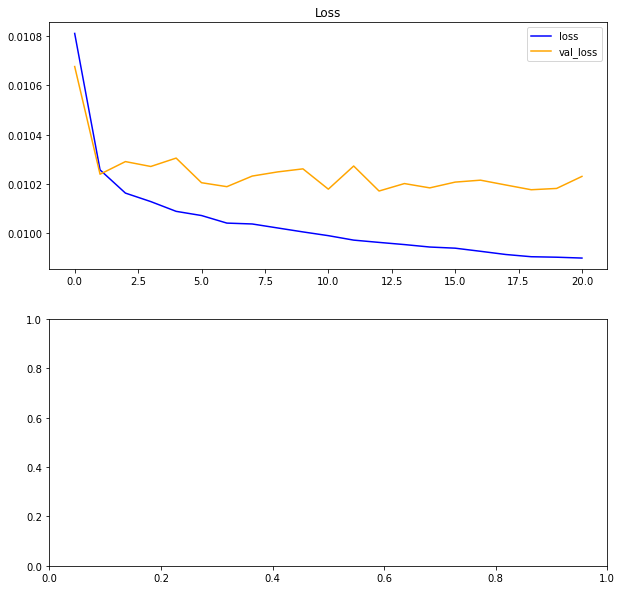

Accuracy: mean=66.244 std=0.000, n=1


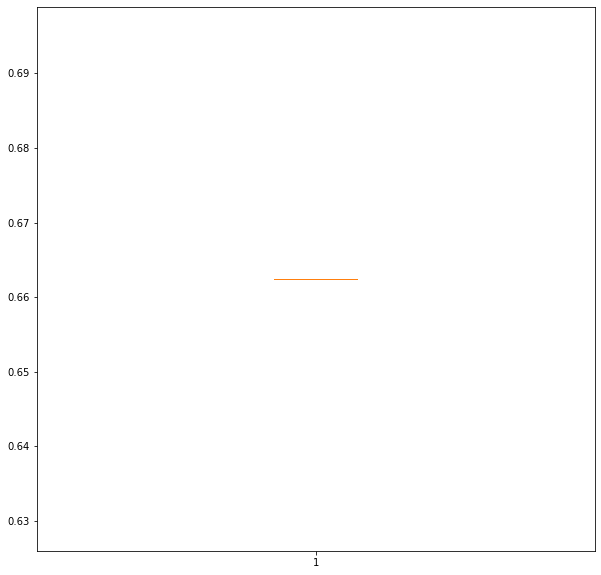

Scores:  [0.6624427437782288]
MWMW  (251249, 11)
MWMW  (76801, 11)
MWMW  (174448, 11)
Number of ROC thresholds:  (248801,)
getAuc area & max(y):  0.889982391641717 1.0
auc =  0.889982391641717
getAuc area & max(y):  0.889982391641717 1.0


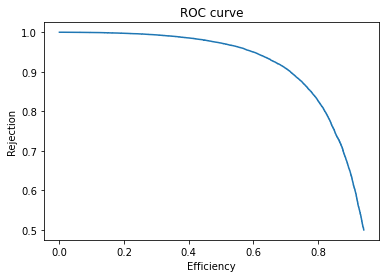

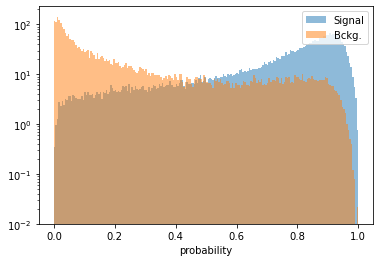

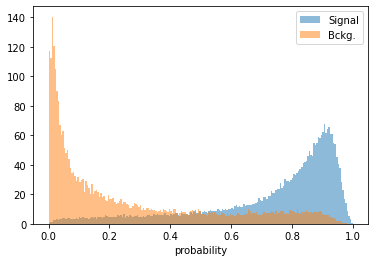

signal_mass =  600.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2445/2445 [==============================] - 24s 9ms/step - loss: 0.0095 - val_loss: 0.0089 - lr: 1.0000e-04
Epoch 2/200
2445/2445 [==============================] - 12s 5ms/step - loss: 0.0089 - val_loss: 0.0088 - lr: 9.6000e-05
Epoch 3/200
2445/2445 [==============================] - 11s 4ms/step - loss: 0.0088 - val_loss: 0.0087 - lr: 9.2160e-05
Epoch 4/200
2445/2445 [==============================] - 11s 5ms/step - loss: 0.0087 - val_loss: 0.0087 - lr: 8.8474e-05
Epoch 5/200
2445/2445 [==============================] - 11s 5ms/step - loss: 0.0087 - val_loss: 0.0087 - lr: 8.4935e-05
Epoch 6/200
2445/2445 [==============================] - 11s 4ms/step - loss: 0.0086 - val_loss: 0.0087 - lr: 8.1537e-05
Epoch 7/200
2445/2445 [==============================] - 11s 5ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 7.8276e-05
Epoch 8/200


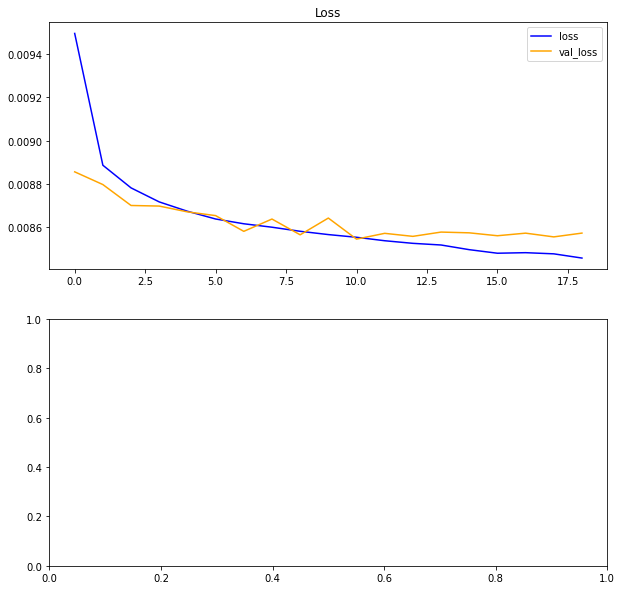

Accuracy: mean=76.906 std=0.000, n=1


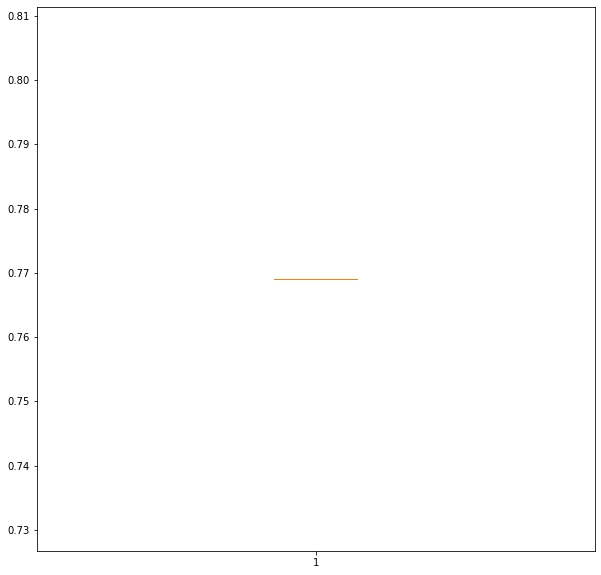

Scores:  [0.7690591812133789]
MWMW  (230764, 11)
MWMW  (57040, 11)
MWMW  (173724, 11)
Number of ROC thresholds:  (228209,)
getAuc area & max(y):  0.9352886451243485 1.0
auc =  0.9352886451243485
getAuc area & max(y):  0.9352886451243482 1.0


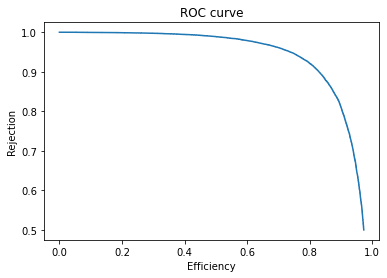

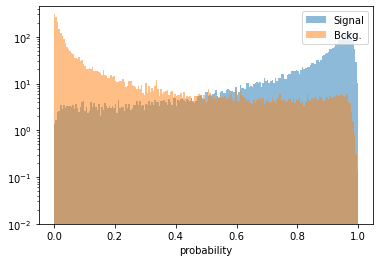

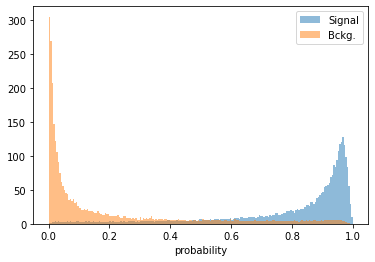

signal_mass =  700.0000000000001
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2547/2547 [==============================] - 26s 10ms/step - loss: 0.0070 - val_loss: 0.0067 - lr: 1.0000e-04
Epoch 2/200
2547/2547 [==============================] - 12s 5ms/step - loss: 0.0065 - val_loss: 0.0066 - lr: 9.6000e-05
Epoch 3/200
2547/2547 [==============================] - 14s 5ms/step - loss: 0.0065 - val_loss: 0.0066 - lr: 9.2160e-05
Epoch 4/200
2547/2547 [==============================] - 12s 5ms/step - loss: 0.0064 - val_loss: 0.0066 - lr: 8.8474e-05
Epoch 5/200
2547/2547 [==============================] - 12s 5ms/step - loss: 0.0064 - val_loss: 0.0066 - lr: 8.4935e-05
Epoch 6/200
2547/2547 [==============================] - 12s 5ms/step - loss: 0.0063 - val_loss: 0.0066 - lr: 8.1537e-05
Epoch 7/200
2547/2547 [==============================] - 12s 5ms/step - loss: 0.0063 - val_loss: 0.0066 - lr: 7.8276e-05

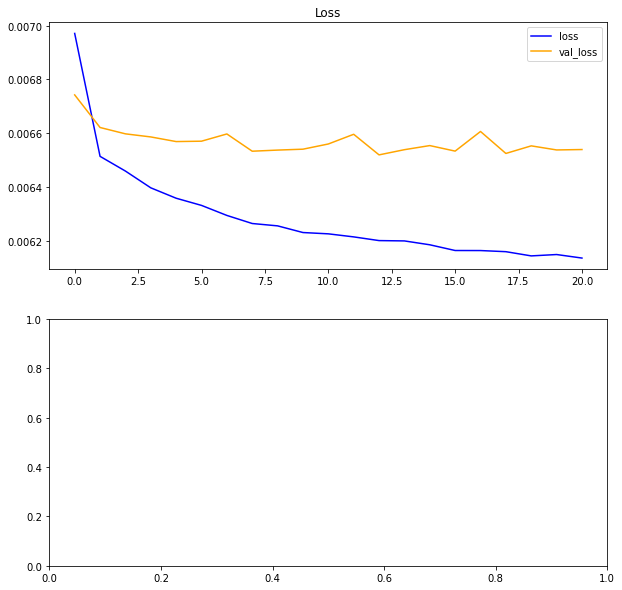

Accuracy: mean=80.296 std=0.000, n=1


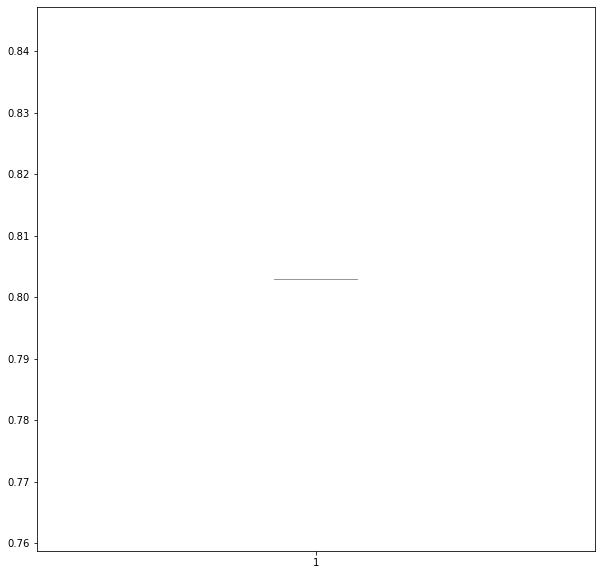

Scores:  [0.8029636740684509]
MWMW  (241243, 11)
MWMW  (66974, 11)
MWMW  (174269, 11)
Number of ROC thresholds:  (236169,)
getAuc area & max(y):  0.9614161109340366 1.0
auc =  0.9614161109340366
getAuc area & max(y):  0.9614161109340364 1.0


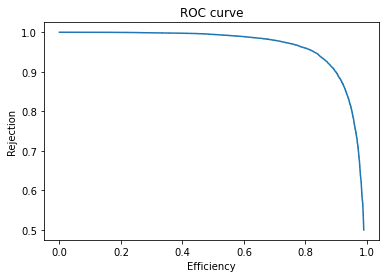

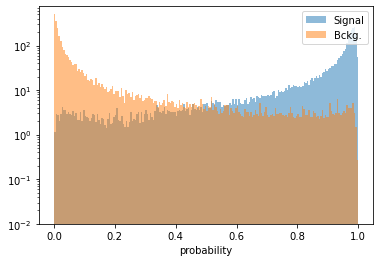

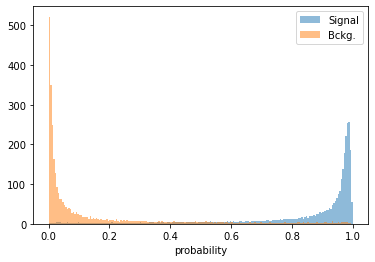

signal_mass =  800.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2563/2563 [==============================] - 27s 9ms/step - loss: 0.0054 - val_loss: 0.0050 - lr: 1.0000e-04
Epoch 2/200
2563/2563 [==============================] - 12s 5ms/step - loss: 0.0049 - val_loss: 0.0049 - lr: 9.6000e-05
Epoch 3/200
2563/2563 [==============================] - 12s 5ms/step - loss: 0.0049 - val_loss: 0.0048 - lr: 9.2160e-05
Epoch 4/200
2563/2563 [==============================] - 11s 4ms/step - loss: 0.0049 - val_loss: 0.0048 - lr: 8.8474e-05
Epoch 5/200
2563/2563 [==============================] - 12s 5ms/step - loss: 0.0048 - val_loss: 0.0048 - lr: 8.4935e-05
Epoch 6/200
2563/2563 [==============================] - 12s 5ms/step - loss: 0.0048 - val_loss: 0.0048 - lr: 8.1537e-05
Epoch 7/200
2563/2563 [==============================] - 12s 5ms/step - loss: 0.0048 - val_loss: 0.0048 - lr: 7.8276e-05
Epoch 8/200


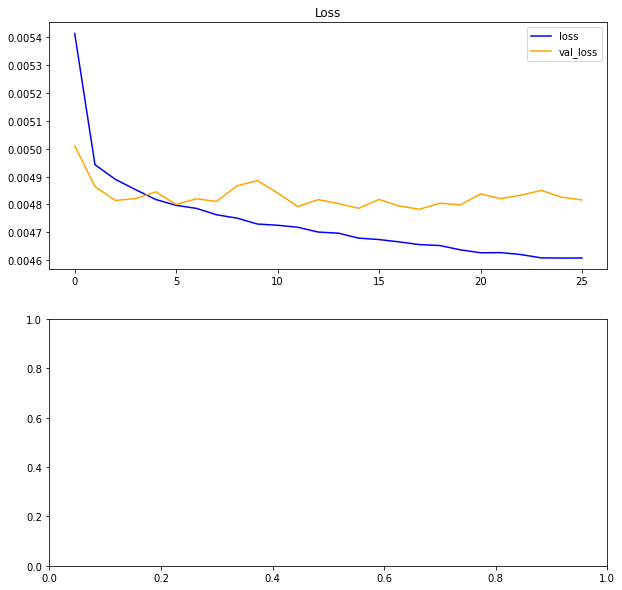

Accuracy: mean=125.092 std=0.000, n=1


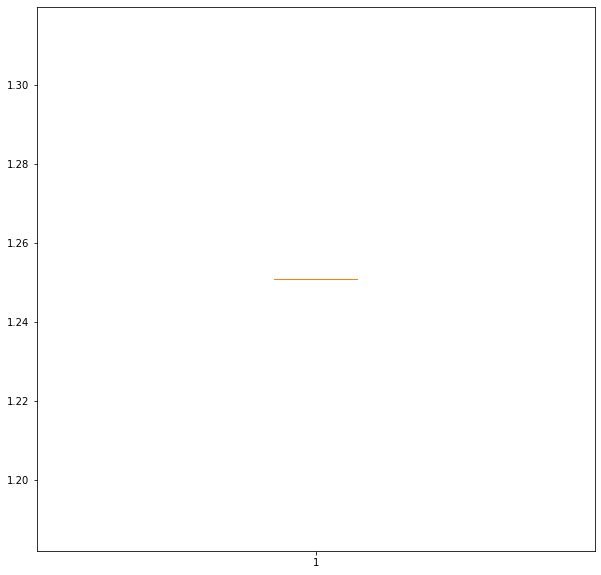

Scores:  [1.250915288925171]
MWMW  (242064, 11)
MWMW  (68035, 11)
MWMW  (174029, 11)
Number of ROC thresholds:  (224071,)
getAuc area & max(y):  0.9766956196840783 1.0
auc =  0.9766956196840783
getAuc area & max(y):  0.9766956196840784 1.0


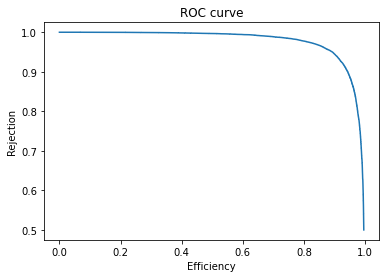

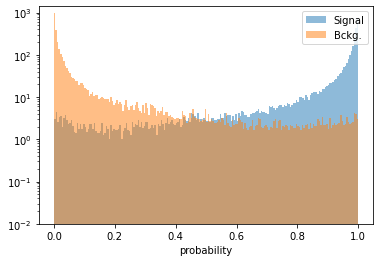

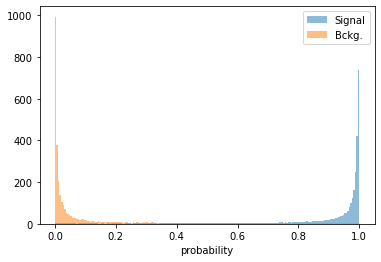

signal_mass =  1000.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2507/2507 [==============================] - 24s 9ms/step - loss: 0.0038 - val_loss: 0.0034 - lr: 1.0000e-04
Epoch 2/200
2507/2507 [==============================] - 11s 5ms/step - loss: 0.0034 - val_loss: 0.0034 - lr: 9.6000e-05
Epoch 3/200
2507/2507 [==============================] - 12s 5ms/step - loss: 0.0033 - val_loss: 0.0033 - lr: 9.2160e-05
Epoch 4/200
2507/2507 [==============================] - 12s 5ms/step - loss: 0.0033 - val_loss: 0.0033 - lr: 8.8474e-05
Epoch 5/200
2507/2507 [==============================] - 12s 5ms/step - loss: 0.0033 - val_loss: 0.0032 - lr: 8.4935e-05
Epoch 6/200
2507/2507 [==============================] - 12s 5ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 8.1537e-05
Epoch 7/200
2507/2507 [==============================] - 11s 4ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 7.8276e-05
Epoch 8/200

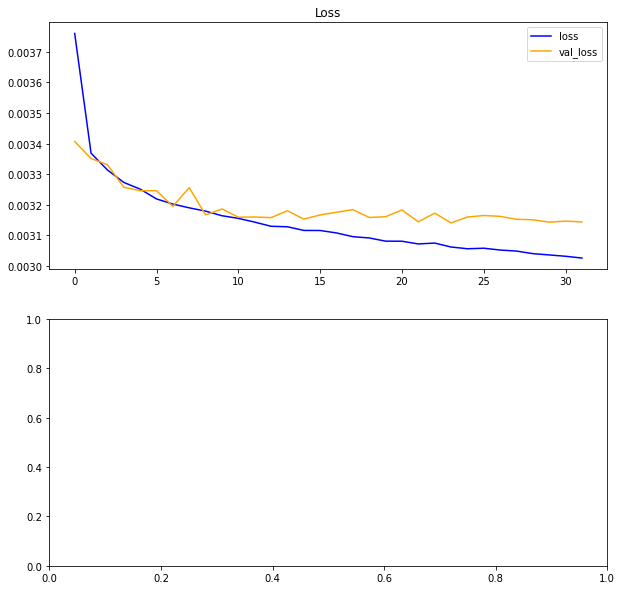

Accuracy: mean=134.725 std=0.000, n=1


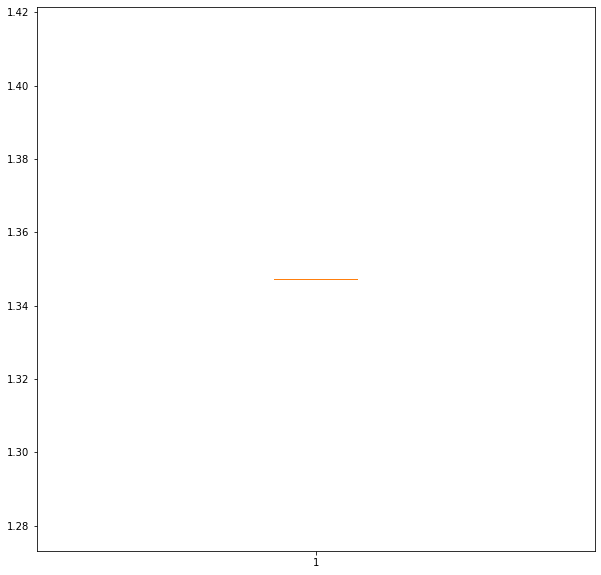

Scores:  [1.347247838973999]
MWMW  (237036, 11)
MWMW  (63298, 11)
MWMW  (173738, 11)
Number of ROC thresholds:  (197709,)
getAuc area & max(y):  0.9891058408108202 1.0
auc =  0.9891058408108202
getAuc area & max(y):  0.9891058408108201 1.0


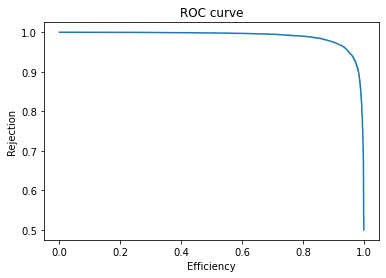

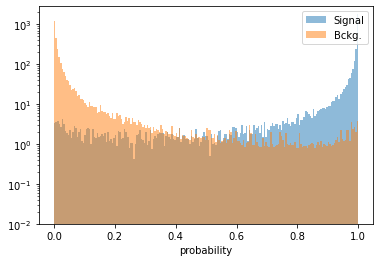

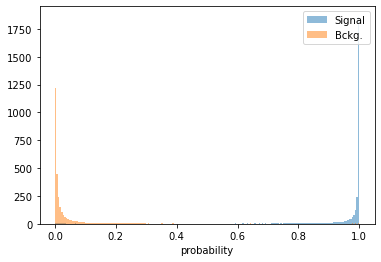

signal_mass =  1200.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2394/2394 [==============================] - 24s 9ms/step - loss: 0.0031 - val_loss: 0.0031 - lr: 1.0000e-04
Epoch 2/200
2394/2394 [==============================] - 12s 5ms/step - loss: 0.0027 - val_loss: 0.0028 - lr: 9.6000e-05
Epoch 3/200
2394/2394 [==============================] - 12s 5ms/step - loss: 0.0026 - val_loss: 0.0029 - lr: 9.2160e-05
Epoch 4/200
2394/2394 [==============================] - 12s 5ms/step - loss: 0.0026 - val_loss: 0.0029 - lr: 8.8474e-05
Epoch 5/200
2394/2394 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 0.0029 - lr: 8.4935e-05
Epoch 6/200
2394/2394 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 0.0029 - lr: 8.1537e-05
Epoch 7/200
2394/2394 [==============================] - 12s 5ms/step - loss: 0.0025 - val_loss: 0.0029 - lr: 7.8276e-05
Epoch 8/200

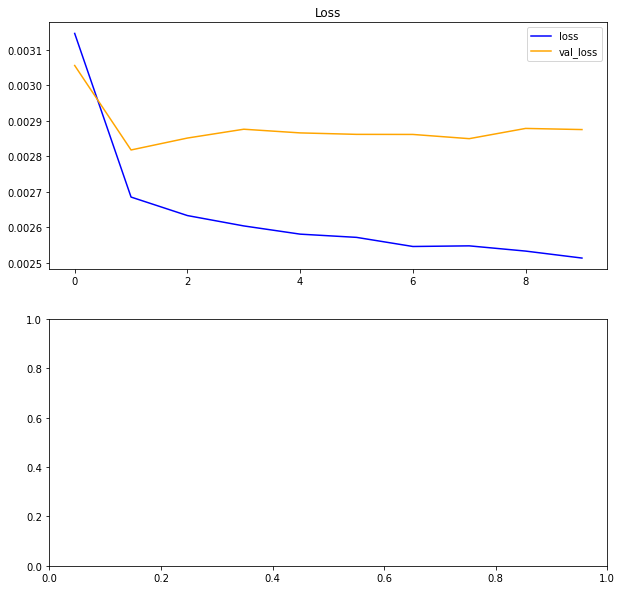

Accuracy: mean=119.232 std=0.000, n=1


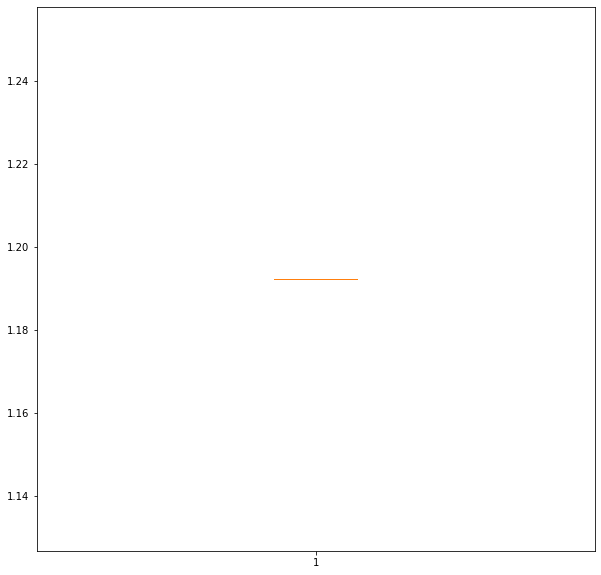

Scores:  [1.1923153400421143]
MWMW  (226699, 11)
MWMW  (52253, 11)
MWMW  (174446, 11)
Number of ROC thresholds:  (187941,)
getAuc area & max(y):  0.9937955102659071 1.0
auc =  0.9937955102659071
getAuc area & max(y):  0.9937955102659068 1.0


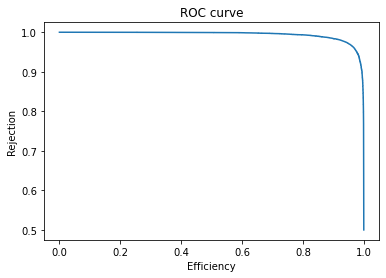

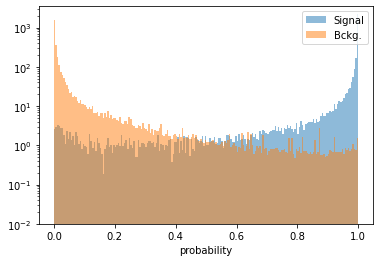

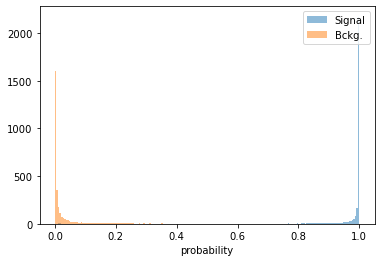

signal_mass =  1500.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2292/2292 [==============================] - 23s 9ms/step - loss: 0.0016 - val_loss: 0.0013 - lr: 1.0000e-04
Epoch 2/200
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 9.6000e-05
Epoch 3/200
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 9.2160e-05
Epoch 4/200
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 8.8474e-05
Epoch 5/200
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 8.4935e-05
Epoch 6/200
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 8.1537e-05
Epoch 7/200
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 7.8276e-05
Epoch 8/200

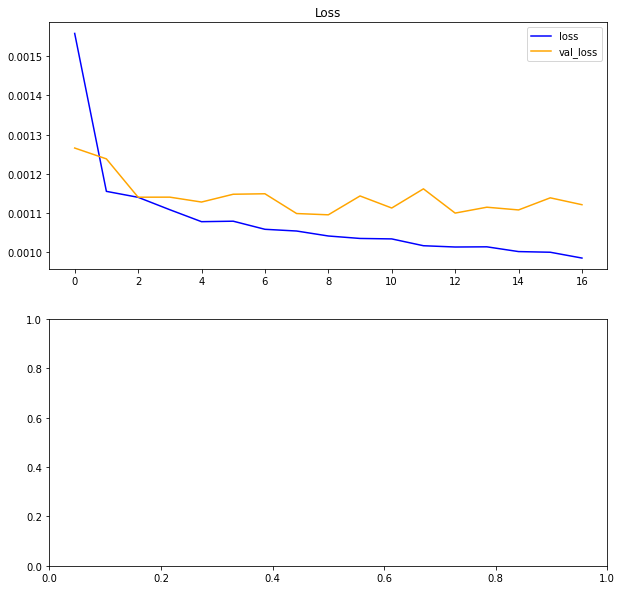

Accuracy: mean=107.418 std=0.000, n=1


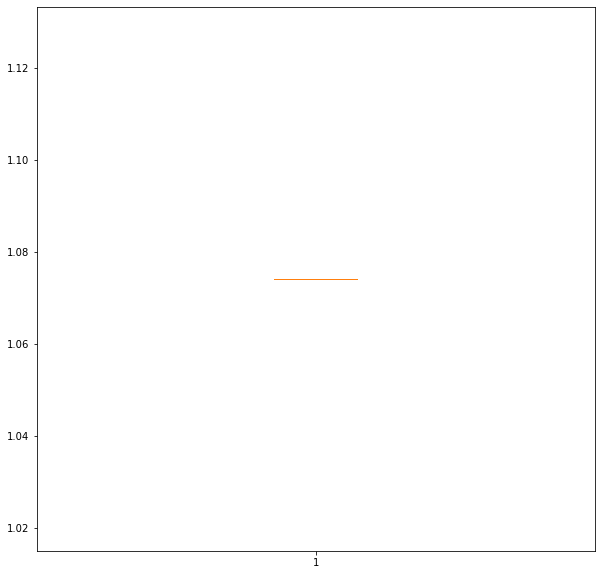

Scores:  [1.0741811990737915]
MWMW  (217802, 11)
MWMW  (43320, 11)
MWMW  (174482, 11)
Number of ROC thresholds:  (176436,)
getAuc area & max(y):  0.9988921056659112 1.0
auc =  0.9988921056659112
getAuc area & max(y):  0.9988921056659115 1.0


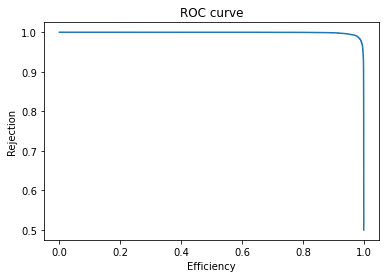

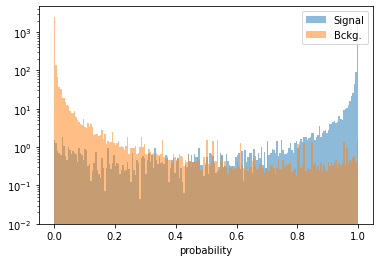

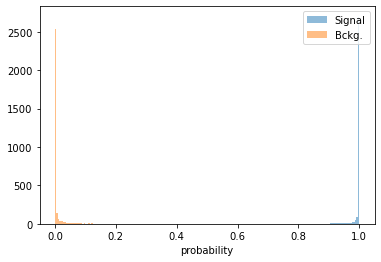

signal_mass =  2000.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2234/2234 [==============================] - 23s 10ms/step - loss: 9.7635e-04 - val_loss: 7.3612e-04 - lr: 1.0000e-04
Epoch 2/200
2234/2234 [==============================] - 11s 5ms/step - loss: 6.3146e-04 - val_loss: 7.6360e-04 - lr: 9.6000e-05
Epoch 3/200
2234/2234 [==============================] - 10s 5ms/step - loss: 6.0033e-04 - val_loss: 7.2793e-04 - lr: 9.2160e-05
Epoch 4/200
2234/2234 [==============================] - 13s 6ms/step - loss: 5.7797e-04 - val_loss: 6.8123e-04 - lr: 8.8474e-05
Epoch 5/200
2234/2234 [==============================] - 10s 5ms/step - loss: 5.5595e-04 - val_loss: 6.8314e-04 - lr: 8.4935e-05
Epoch 6/200
2234/2234 [==============================] - 11s 5ms/step - loss: 5.5536e-04 - val_loss: 7.0408e-04 - lr: 8.1537e-05
Epoch 7/200
2234/2234 [==============================] - 11s 5ms/step - loss: 5.479

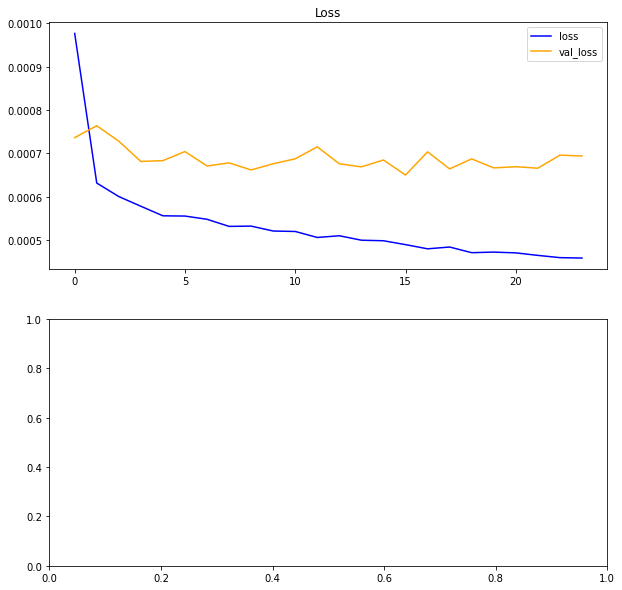

Accuracy: mean=109.806 std=0.000, n=1


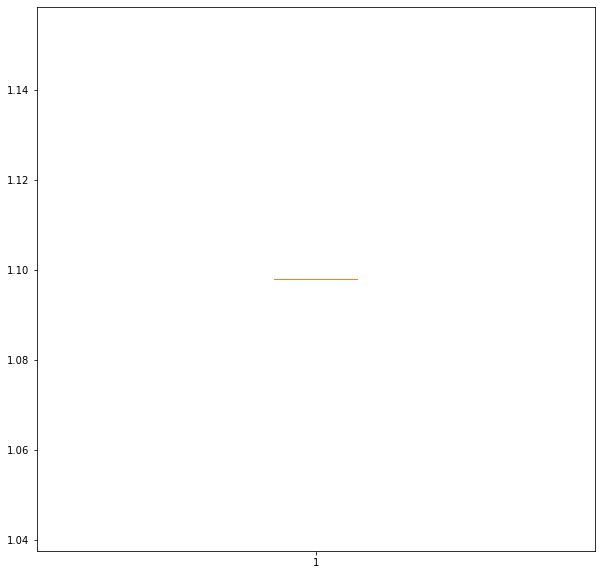

Scores:  [1.0980583429336548]
MWMW  (212399, 11)
MWMW  (37657, 11)
MWMW  (174742, 11)
Number of ROC thresholds:  (168947,)
getAuc area & max(y):  0.999643461976927 1.0
auc =  0.999643461976927
getAuc area & max(y):  0.9996434619769268 1.0


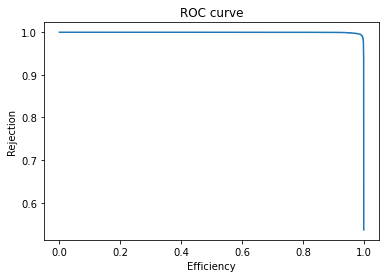

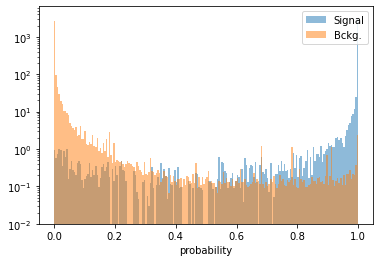

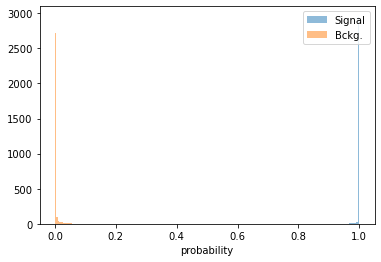

signal_mass =  2500.0
<class 'pandas.core.frame.DataFrame'>
Converting to numpy
Converted to numpy
Defining model
Fit_model
compiling
fitting
Epoch 1/200
2201/2201 [==============================] - 23s 9ms/step - loss: 7.3495e-04 - val_loss: 5.7046e-04 - lr: 1.0000e-04
Epoch 2/200
2201/2201 [==============================] - 10s 5ms/step - loss: 3.8032e-04 - val_loss: 5.6206e-04 - lr: 9.6000e-05
Epoch 3/200
2201/2201 [==============================] - 11s 5ms/step - loss: 3.6367e-04 - val_loss: 4.5339e-04 - lr: 9.2160e-05
Epoch 4/200
2201/2201 [==============================] - 11s 5ms/step - loss: 3.4134e-04 - val_loss: 4.9691e-04 - lr: 8.8474e-05
Epoch 5/200
2201/2201 [==============================] - 10s 5ms/step - loss: 3.4094e-04 - val_loss: 4.2032e-04 - lr: 8.4935e-05
Epoch 6/200
2201/2201 [==============================] - 10s 5ms/step - loss: 3.1361e-04 - val_loss: 4.6329e-04 - lr: 8.1537e-05
Epoch 7/200
2201/2201 [==============================] - 11s 5ms/step - loss: 3.2452

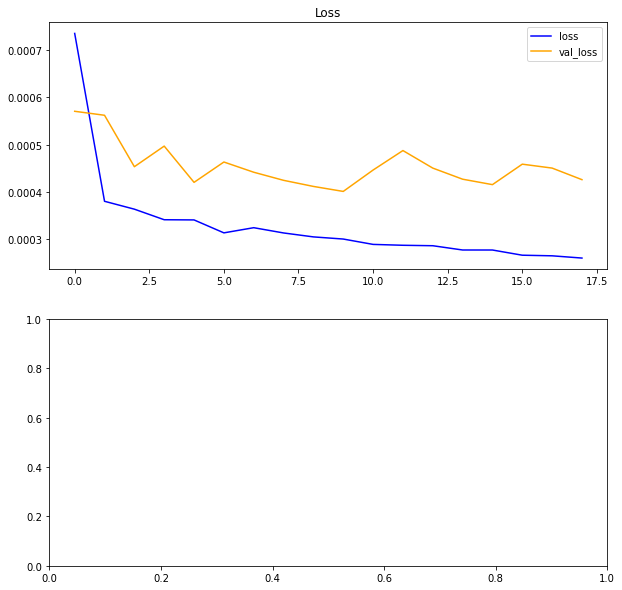

Accuracy: mean=67.660 std=0.000, n=1


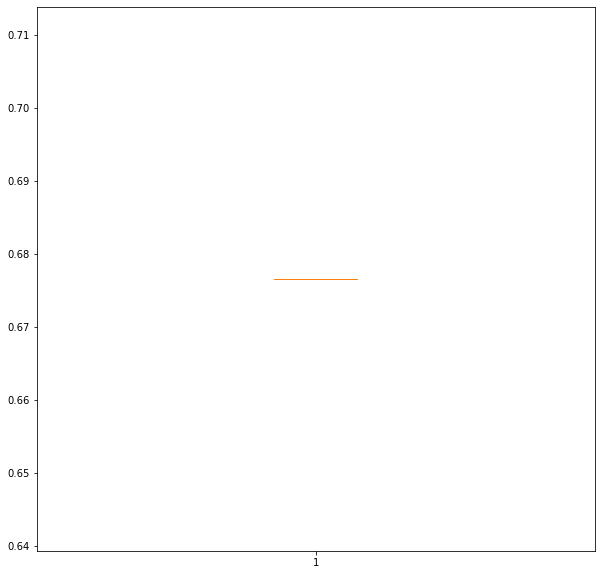

Scores:  [0.6765956878662109]
MWMW  (209119, 11)
MWMW  (34558, 11)
MWMW  (174561, 11)
Number of ROC thresholds:  (171887,)
getAuc area & max(y):  0.9998941095607843 1.0
auc =  0.9998941095607843
getAuc area & max(y):  0.9998941095607843 1.0


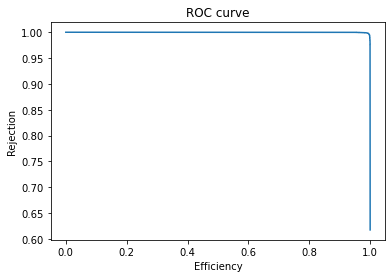

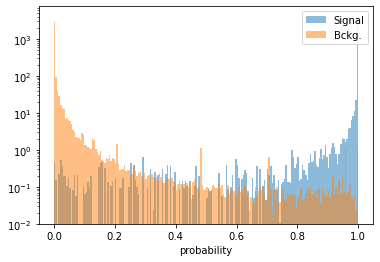

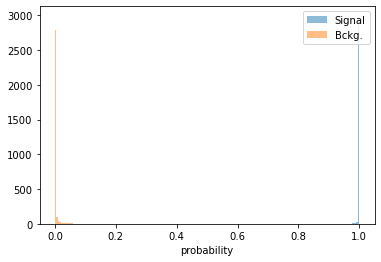

In [29]:
auc_list_sep = []
av_auc_list_sep = []
aucs_list_sep = []


for m in np.divide(masses, 10000.) :  #masses:  # divide mass by 10000
  print("signal_mass = ",m*10000)

  #select events with a given signal_mass from the training dataset...    
  if datatype == 'lephad':  
   mask = np.in1d(x_train_all.signal_mass, m)
  if datatype == 'hadhad':
   mask = np.in1d(x_train_all.sig_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  if datatype == 'lephad':  
   mask = np.in1d(x_test_all.signal_mass, m)
  if datatype == 'hadhad':
   mask = np.in1d(x_test_all.sig_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[0].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list_sep.append(auc)
  av_auc_list_sep.append(av_auc)
  aucs_list_sep.append(aucs)
  



Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

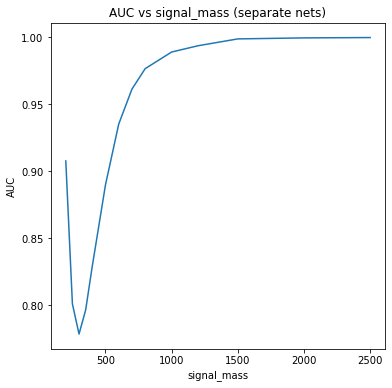

signal_mass  comb. auc  mean auc
0           200   0.907744  0.907744
1           250   0.800998  0.800998
2           300   0.778487  0.778487
3           350   0.796431  0.796431
4           400   0.829075  0.829075
5           500   0.889982  0.889982
6           600   0.935289  0.935289
7           700   0.961416  0.961416
8           800   0.976696  0.976696
9          1000   0.989106  0.989106
10         1200   0.993796  0.993796
11         1500   0.998892  0.998892
12         2000   0.999643  0.999643
13         2500   0.999894  0.999894

In [30]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()



# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep, av_auc_list_sep)), 
               columns =['signal_mass', 'comb. auc', 'mean auc']) 
aucf